## 1. Importing Necessary Libraries

In [156]:
from pathlib import Path

import numpy as np
import pandas as pd

import sklearn
import xgboost

from sklearn.metrics import r2_score,mean_absolute_error,root_mean_squared_error

from sklearn.linear_model import (
      LinearRegression,
      Ridge,
      Lasso
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (
      RandomForestRegressor,
      AdaBoostRegressor,
      GradientBoostingRegressor
)
from xgboost import XGBRegressor


from sklearn.base import (
    BaseEstimator,
    TransformerMixin
)

from sklearn.impute import (
    SimpleImputer
)

from sklearn.preprocessing import (
	OneHotEncoder,
    OrdinalEncoder,
    TargetEncoder,
    StandardScaler,
    MinMaxScaler,
    FunctionTransformer
)

from sklearn.compose import (
    ColumnTransformer,
    TransformedTargetRegressor
)

from sklearn.pipeline import (
    Pipeline,
    FeatureUnion
)

from feature_engine.encoding import(
    RareLabelEncoder
)

from feature_engine.selection import(
    SelectBySingleFeaturePerformance,
    SmartCorrelatedSelection
)

import matplotlib.pyplot as plt

import optuna

import mlflow

import warnings

## 2. Display settings

In [4]:
pd.set_option("display.max_columns", None)
sklearn.set_config(transform_output = "pandas")
warnings.filterwarnings('ignore')

## 3. Reading The Data

In [6]:
PROJECT_DIR = Path(r"F:\Rishabh\House-Price-Prediction-MLOps-Project")
DATA_DIR = "data"

In [7]:
def read_data(name):
    file_name = f"{name}.csv"
    file_path = PROJECT_DIR/DATA_DIR/name/file_name

    return pd.read_csv(file_path)

In [8]:
train = read_data("train")

In [9]:
val = read_data("val")

In [10]:
test = read_data("test")

In [11]:
X_train = train.drop(columns = ["amount"])
y_train = train.amount.copy()

X_val = val.drop(columns = ["amount"])
y_val = val.amount.copy()

X_test = test.drop(columns = ["amount"])
y_test = test.amount.copy()

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(42129, 18)
(42129,)
(4681, 18)
(4681,)
(5202, 18)
(5202,)


## 4. Feature Engineering Pipeline

In [80]:
# Function to rename the columns before putting back into imputation pipeline
def prefix_remover(X, prefixes):

    prefix_list = [f"{prefix}__" for prefix in prefixes]
    new_cols = X.columns
    
    for prefix in prefix_list:
        new_cols = [col.replace(prefix,"") if col.startswith(prefix) else col for col in new_cols]

    return X.rename(
        columns = dict(zip(X.columns,new_cols))
    )

# imputer to impute bathroom values based on num_bhk
class GroupAggregateImputer(BaseEstimator, TransformerMixin):

    def __init__(self,variable,group_col,estimator,add_indicator = False):
        self.variable = variable
        self.group_col = group_col
        self.estimator = estimator
        self.add_indicator = add_indicator

    def fit(self,X,y = None):

        self.group_medians_ = {}
        self.group_modes_ = {}

        if self.estimator == "median":
                self.group_medians_[self.variable] =  X.groupby(self.group_col)[self.variable].median()
                
        elif self.estimator == "mode":
                self.group_modes_[self.variable] =  X.groupby(self.group_col)[self.variable].agg(lambda x: x.mode().iloc[0])
            
        return self

    def transform(self,X):
       X = X.copy()

       if self.add_indicator:
           X = X.assign(**{
               f"{self.variable}_missingindicator" : lambda df:(
                     np.where(
                         df[self.variable].isnull(),
                         1,0
                     )
                 )
           })

       if self.estimator == "median":
               mask = X[self.variable].isnull()
               X.loc[mask,self.variable] = X.loc[mask,self.group_col].map(self.group_medians_[self.variable])
               
       elif self.estimator == "mode":
               mask = X[self.variable].isnull()
               X.loc[mask,self.variable] = X.loc[mask,self.group_col].map(self.group_modes_[self.variable]) 

       
       return X

# Imputation pipeline

furnishing_imputer = ColumnTransformer(transformers = [
    ("furnishing_imputer",GroupAggregateImputer(variable = "furnishing",group_col = "transaction",estimator = "mode"),["furnishing","transaction"])
],remainder = "passthrough")

furnishing_imputation_pipeline = Pipeline(steps = [
    ("furnishing_imputer",furnishing_imputer),
    ("prefix_remover",FunctionTransformer(func = prefix_remover, kw_args = {"prefixes" : ["furnishing_imputer","remainder"]}))
])

floor_num_imputer = ColumnTransformer(transformers = [
    ("floor_num_imputer",SimpleImputer(strategy = "median"),["floor_num"])
],remainder = "passthrough")

floor_num_imputation_pipeline = Pipeline(steps = [
    ("floor_num_imputer",floor_num_imputer),
    ("prefix_remover",FunctionTransformer(func = prefix_remover, kw_args = {"prefixes" : ["floor_num_imputer","remainder"]}))
])

num_floors_imputer = ColumnTransformer(transformers = [
    ("num_floors_imputer",GroupAggregateImputer(variable = "num_floors",group_col = "floor_num",estimator = "median"),["num_floors","floor_num"])
],remainder = "passthrough")

num_floors_imputation_pipeline = Pipeline(steps = [
    ("num_floors_imputer",num_floors_imputer),
    ("prefix_remover",FunctionTransformer(func = prefix_remover, kw_args = {"prefixes" : ["num_floors_imputer","remainder"]}))
])

balcony_imputer = ColumnTransformer(transformers = [
    ("balcony_imputer", GroupAggregateImputer(variable = "balcony",group_col = "num_bhk",estimator = "median", add_indicator = True),["balcony","num_bhk"])
],remainder = "passthrough")

balcony_imputation_pipeline = Pipeline(steps = [
    ("balcony_imputer",balcony_imputer),
    ("prefix_remover",FunctionTransformer(func = prefix_remover, kw_args = {"prefixes" : ["balcony_imputer","remainder"]}))
])

ownership_imputer = ColumnTransformer(transformers = [
    ("ownership_imputer",SimpleImputer(strategy = 'most_frequent',add_indicator = True),["ownership"])
], remainder = "passthrough")


ownership_imputation_pipeline = Pipeline(steps = [
    ("ownership_imputer",ownership_imputer),
    ("prefix_remover",FunctionTransformer(func = prefix_remover, kw_args = {"prefixes" : ["ownership_imputer","remainder"]}))
])

facing_imputer = ColumnTransformer(transformers = [
    ("facing_imputer",SimpleImputer(strategy = 'constant',fill_value = 'Missing',add_indicator = True),["facing"])
], remainder = "passthrough")

facing_imputation_pipeline = Pipeline(steps = [
    ("facing_imputer",facing_imputer),
    ("prefix_remover",FunctionTransformer(func = prefix_remover, kw_args = {"prefixes" : ["facing_imputer","remainder"]}))
])

overlooking_garden_imputer = ColumnTransformer(transformers = [
    ("overlooking_garden_imputer",SimpleImputer(strategy = 'constant',fill_value = -1),["overlooking_garden"])
], remainder = "passthrough")

overlooking_garden_imputation_pipeline = Pipeline(steps = [
    ("overlooking_garden_imputer",overlooking_garden_imputer),
    ("prefix_remover",FunctionTransformer(func = prefix_remover, kw_args = {"prefixes" : ["overlooking_garden_imputer","remainder"]}))
])

overlooking_mainroad_imputer = ColumnTransformer(transformers = [
    ("overlooking_mainroad_imputer",SimpleImputer(strategy = 'constant',fill_value = -1),["overlooking_mainroad"])
], remainder = "passthrough")

overlooking_mainroad_imputation_pipeline = Pipeline(steps = [
    ("overlooking_mainroad_imputer",overlooking_mainroad_imputer),
    ("prefix_remover",FunctionTransformer(func = prefix_remover, kw_args = {"prefixes" : ["overlooking_mainroad_imputer","remainder"]}))
])

overlooking_pool_imputer = ColumnTransformer(transformers = [
    ("overlooking_pool_imputer",SimpleImputer(strategy = 'constant',fill_value = -1),["overlooking_pool"])
], remainder = "passthrough")

overlooking_pool_imputation_pipeline = Pipeline(steps = [
    ("overlooking_pool_imputer",overlooking_pool_imputer),
    ("prefix_remover",FunctionTransformer(func = prefix_remover, kw_args = {"prefixes" : ["overlooking_pool_imputer","remainder"]}))
])

parking_cover_imputer =  ColumnTransformer(transformers = [
    ("parking_cover_imputer",SimpleImputer(strategy = 'constant',fill_value = "No parking"),["parking_cover"])
],remainder = "passthrough")

parking_cover_imputation_pipeline = Pipeline(steps = [
    ("parking_cover_imputer",parking_cover_imputer),
    ("prefix_remover",FunctionTransformer(func = prefix_remover, kw_args = {"prefixes" : ["parking_cover_imputer","remainder"]}))
])

parking_spots_imputer =  ColumnTransformer(transformers = [
    ("parking_spots_imputer",SimpleImputer(strategy = 'constant',fill_value = 0),["parking_spots"])
],remainder = "passthrough")

parking_spots_imputation_pipeline = Pipeline(steps = [
    ("parking_spots_imputer",parking_spots_imputer),
    ("prefix_remover",FunctionTransformer(func = prefix_remover, kw_args = {"prefixes" : ["parking_spots_imputer","remainder"]}))
])

carpet_area_imputer =  ColumnTransformer(transformers = [
    ("carpet_area_imputer",SimpleImputer(strategy = 'constant',fill_value = -1),["carpet_area"])
],remainder = "passthrough")

carpet_area_imputation_pipeline = Pipeline(steps = [
    ("carpet_area_imputer",carpet_area_imputer),
    ("prefix_remover",FunctionTransformer(func = prefix_remover, kw_args = {"prefixes" : ["carpet_area_imputer","remainder"]}))
])

super_area_imputer =  ColumnTransformer(transformers = [
    ("super_area_imputer",SimpleImputer(strategy = 'constant',fill_value = -1),["super_area"])
],remainder = "passthrough")

super_area_imputation_pipeline = Pipeline(steps = [
    ("super_area_imputer",super_area_imputer),
    ("prefix_remover",FunctionTransformer(func = prefix_remover, kw_args = {"prefixes" : ["super_area_imputer","remainder"]}))
])

imputation_pipeline = Pipeline(steps = [
    ("furnishing_imputation_pipeline",furnishing_imputation_pipeline),
    ("floor_num_imputation_pipeline",floor_num_imputation_pipeline),
    ("num_floors_imputation_pipeline",num_floors_imputation_pipeline),
    ("balcony_imputation_pipeline",balcony_imputation_pipeline),
    ("ownership_imputation_pipeline",ownership_imputation_pipeline),
    ("facing_imputation_pipeline",facing_imputation_pipeline),
    ("overlooking_garden_imputation_pipeline",overlooking_garden_imputation_pipeline),
    ("overlooking_mainroad_imputation_pipeline",overlooking_mainroad_imputation_pipeline),
    ("overlooking_pool_imputation_pipeline",overlooking_pool_imputation_pipeline),
    ("parking_cover_imputation_pipeline",parking_cover_imputation_pipeline),
    ("parking_spots_imputation_pipeline",parking_spots_imputation_pipeline),
    ("carpet_area_imputation_pipeline",carpet_area_imputation_pipeline),
    ("super_area_imputation_pipeline",super_area_imputation_pipeline)
])

# Column transformers

transaction_transformer = Pipeline(steps = [
    ("grouper",RareLabelEncoder(tol = 0.1, n_categories = 2, replace_with = "Resale")),
    ("encoder",OneHotEncoder(sparse_output = False,handle_unknown = 'ignore'))
])

def house_size_binner(X):
    columns = X.columns.to_list()

    return (
        X.assign(
               house_size = lambda df: (
                np.select(
                [
                    df.num_bhk.between(1,3,inclusive = "left"),
                    df.num_bhk.between(3,4,inclusive = "left")
                ],
                ["small","normal"],
                default = "big"
               )
            ) 
        )
        .drop(columns = columns)
    )

num_bhk_pipe1 = Pipeline(steps = [
    ("scaler",MinMaxScaler())
])

num_bhk_pipe2 = Pipeline(steps = [
    ("house_size_binner",FunctionTransformer(func = house_size_binner)),
    ("encoder",OrdinalEncoder(categories = [["small","normal","big"]]))
])

num_bhk_transformer = FeatureUnion(transformer_list = [
    ("num_bhk_pipe1",num_bhk_pipe1),
    ("num_bhk_pipe2",num_bhk_pipe2)
])

def bathroom_num_binner(X):
    columns = X.columns.to_list()

    return (
        X.assign(
               bathroom_num = lambda df: (
                np.select(
                [
                    df.bathroom.between(1,3,inclusive = "left"),
                    df.bathroom.between(3,4,inclusive = "left")
                ],
                ["low","medium"],
                default = "high"
              )
            ) 
        )
        .drop(columns = columns)
    )

bathroom_pipe1 = Pipeline(steps = [
    ("scaler",MinMaxScaler())
])

bathroom_pipe2 = Pipeline(steps = [
    ("bathroom_num_binner",FunctionTransformer(func = bathroom_num_binner)),
    ("encoder",OrdinalEncoder(categories = [["low","medium","high"]]))
])

bathroom_transformer = FeatureUnion(transformer_list = [
    ("bathroom_pipe1",bathroom_pipe1),
    ("bathroom_pipe2",bathroom_pipe2)
])

def bathroom_num_binner(X):
    columns = X.columns.to_list()

    return (
        X.assign(
               bathroom_num = lambda df: (
                np.select(
                [
                    df.bathroom.between(1,3,inclusive = "left"),
                    df.bathroom.between(3,4,inclusive = "left")
                ],
                ["low","medium"],
                default = "high"
              )
            ) 
        )
        .drop(columns = columns)
    )

furnishing_pipe1 = Pipeline(steps = [
    ("encoder",OrdinalEncoder(categories = [["Unfurnished","Semi-Furnished","Furnished"]])),
])

furnishing_pipe2 = Pipeline(steps = [
    ("is_unfurnished",FunctionTransformer(func = lambda x: np.where(x == 'Unfurnished',1,0)))
])

furnishing_transformer = FeatureUnion(transformer_list = [
    ("furnishing_pipe1",furnishing_pipe1),
    ("furnishing_pipe2",furnishing_pipe2)
])

def floor_height_binner(X):

    columns = X.columns.to_list()

    return (
        X.assign(
            floor_height = lambda df:(
                    np.select(
                        [
                            (df.floor_num.between(0,3, inclusive = "left")),
                            (df.floor_num.between(3,6, inclusive = "left"))
                        ],
                        ["low","medium"],
                        default = "high"
                    )
            )
        )
        .drop(columns = columns)
    )

def building_height_binner(X):

    columns = X.columns.to_list()

    return (
        X.assign(
            building_height = lambda df:(
                np.select(
                [
                    (df.num_floors.between(0,5, inclusive = "left")),
                    (df.num_floors.between(5,13, inclusive = "left"))
                ],
                ["short","medium"],
                default = "tall"
            )
            )
        )
        .drop(columns = columns)
    )

floor_num_pipe1 = Pipeline(steps = [
    ("scaler",StandardScaler())
])

floor_num_pipe2 = Pipeline(steps = [
    ("floor_height_binner",FunctionTransformer(func = floor_height_binner)),
    ("encoder",OrdinalEncoder(categories = [["low","medium","high"]])),
])

floor_num_transformer = FeatureUnion(transformer_list = [
    ("floor_num_pipe1",floor_num_pipe1),
    ("floor_num_pipe2",floor_num_pipe2)
])

num_floors_pipe1 = Pipeline(steps = [
    ("scaler",StandardScaler())
])

num_floors_pipe2 = Pipeline(steps = [
    ("building_height_binner",FunctionTransformer(func = building_height_binner)),
    ("encoder",OrdinalEncoder(categories = [["short","medium","tall"]]))
])

num_floors_transformer = FeatureUnion(transformer_list = [
    ("num_floors_pipe1",num_floors_pipe1),
    ("num_floors_pipe2",num_floors_pipe2)
])

def city_binner(X):
    
     columns = X.columns.to_list()

     return (
        X.assign(
            city_tier = lambda df:(
                np.where(
                    df.location.isin(["mumbai","gurgaon","new-delhi"]),
                    1,
                    0
                )
            )
        )
        .drop(columns = columns)
    )

location_pipe1 = Pipeline(steps = [
    ("target_encoder", TargetEncoder())
])

location_pipe2 = Pipeline(steps = [
    ("city_binner",FunctionTransformer(func = city_binner))
])

location_transformer = FeatureUnion(transformer_list = [
    ("location_pipe1",location_pipe1),
    ("location_pipe2",location_pipe2)
])

def price_binner(X):

    columns = X.columns.to_list()

    return (
        X.assign(
               price_range = lambda df:(
                np.select(
                    [
                        df.price.between(0,4000,inclusive = "left"),
                        df.price.between(4000,6000,inclusive = "left")
                    ],
                    ["low","medium"],
                    default = "high"
                )
            )
        )
        .drop(columns = columns)
    )

balcony_transformer = Pipeline(steps = [
    ("nearest_integer",FunctionTransformer(func = lambda x : np.round(x))),
    ("scaler",MinMaxScaler())
])

ownership_transformer = Pipeline(steps = [
    ("encoder",OneHotEncoder(sparse_output = False,handle_unknown = 'ignore'))
])

missingindicator_ownership_transformer = Pipeline(steps = [
    ("encoder",OneHotEncoder(drop = 'first',sparse_output = False,handle_unknown = 'ignore'))
])

def direction_binner(X):

     columns = X.columns.to_list()

     return (
        X.assign(
            direction_tier = lambda df:(
                np.where(
                    df.facing.isin(["North - East","North - West"]),
                    1,
                    0
                )
            )
        )
        .drop(columns = columns)
     )

facing_pipe1 = Pipeline(steps = [
    ("encoder",OneHotEncoder(sparse_output = False,handle_unknown = 'ignore'))
])

facing_pipe2 = Pipeline(steps = [
    ("direction_binner",FunctionTransformer(func = direction_binner))
])

facing_transformer = FeatureUnion(transformer_list = [
    ("facing_pipe1",facing_pipe1),
    ("facing_pipe2",facing_pipe2)
])

missingindicator_facing_transformer = Pipeline(steps = [
    ("encoder",OneHotEncoder(drop = 'first',sparse_output = False,handle_unknown = 'ignore'))
])

overlooking_garden_transformer = Pipeline(steps = [
    ("encoder",OneHotEncoder(sparse_output = False,handle_unknown = 'ignore'))
])

overlooking_mainroad_transformer = Pipeline(steps = [
    ("encoder",OneHotEncoder(categories=[[ -1, 0, 1 ]], drop=[-1], sparse_output=False, handle_unknown='ignore'))
])

overlooking_pool_transformer = Pipeline(steps = [
    ("encoder",OneHotEncoder(categories=[[ -1, 0, 1 ]], drop=[-1], sparse_output=False, handle_unknown='ignore'))
])

parking_cover_transformer = Pipeline(steps = [
    ("encoder",OneHotEncoder(sparse_output = False,handle_unknown = 'ignore'))
])

def has_parking(X):

    columns = X.columns.to_list()

    return (
        X.assign(
            has_parking = lambda df:(
                np.select(
                            [
                                df.parking_spots.eq(0),
                                df.parking_spots.eq(1)
                            ],
                            ["no parking","single"],
                            default = "multiple"
                        )
            )
        )
        .drop(columns = columns)
     )

parking_spots_transformer = Pipeline(steps = [
    ("has_parking",FunctionTransformer(func = has_parking)),
    ("encoder",OneHotEncoder(categories = [["multiple","single","no parking"]],drop = [["no parking"]],sparse_output = False,handle_unknown = 'ignore'))
])

def effective_area(X):

    columns = X.columns.to_list()

    return(
        X
        .assign(
            effective_area = lambda df:(
                np.where(
                    df.carpet_area.eq(-1),
                    df.super_area,
                    df.carpet_area
                )
            ),
            carpet_areamissing = lambda df:(
                np.where(
                    df.carpet_area.eq(-1),
                    1,
                    0
                )
            ),
            super_areamissing = lambda df:(
                np.where(
                    df.super_area.eq(-1),
                    1,
                    0
                )
            )
        )
        .drop(columns = columns)
    )

scaler_pipeline = Pipeline(steps = [
    ("log_transformer",FunctionTransformer(func = lambda x: np.log(x))),
    ("scaler",StandardScaler())
])

area_transformer = Pipeline(steps = [
    ("effective_area",FunctionTransformer(func = effective_area)),
    ("scaler_pipeline",ColumnTransformer(transformers = [
        ("scaler_pipeline",scaler_pipeline,["effective_area"])
    ],remainder = "passthrough")),
])

def area_per_room(X):

    columns = X.columns.to_list()

    return(
        X
        .assign(
            area_per_room = lambda df:(
                np.where(
                    df.carpet_area.eq(-1),
                    df.super_area/df.num_bhk,
                    df.carpet_area/df.num_bhk
                )
            )
        )
        .drop(columns = columns)
    )

scaler_pipeline = Pipeline(steps = [
    ("log_transformer",FunctionTransformer(func = lambda x: np.log(x))),
    ("scaler",StandardScaler())
])

area_per_room_transformer = Pipeline(steps = [
    ("area_per_room",FunctionTransformer(func = area_per_room)),
    ("scaler_pipeline",ColumnTransformer(transformers = [
        ("scaler_pipeline",scaler_pipeline,["area_per_room"])
    ],remainder = "passthrough"))
])

def balcony_per_room(X):

    columns = X.columns.to_list()

    return(
        X
        .assign(
            balcony_per_room = lambda df:(
                df.balcony/df.num_bhk
            )
        )
        .drop(columns = columns)
    )

def bathroom_per_room(X):

    columns = X.columns.to_list()

    return(
        X
        .assign(
            bathroom_per_room = lambda df:(
                df.bathroom/df.num_bhk
            )
        )
        .drop(columns = columns)
    )

balcony_per_room_transformer = Pipeline(steps = [
    ("balcony_per_room",FunctionTransformer(func = balcony_per_room))
])

bathroom_per_room_transformer = Pipeline(steps = [
    ("bathroom_per_room",FunctionTransformer(func = bathroom_per_room))
])

column_transformer = ColumnTransformer(transformers = [
    ("transaction_transformer",transaction_transformer,["transaction"]),
    ("num_bhk_transformer",num_bhk_transformer,["num_bhk"]),
    ("bathroom_transformer",bathroom_transformer,["bathroom"]),
    ("furnishing_transformer",furnishing_transformer,["furnishing"]),
    ("floor_num_transformer",floor_num_transformer,["floor_num"]),
    ("num_floors_transformer",num_floors_transformer,["num_floors"]),
    ("location_transformer",location_transformer,["location"]),
    ("balcony_transformer",balcony_transformer,["balcony"]),
    ("ownership_transformer",ownership_transformer,["ownership"]),
    ("missingindicator_ownership_transformer",missingindicator_ownership_transformer,["missingindicator_ownership"]),
    ("facing_transformer",facing_transformer,["facing"]),
    ("missingindicator_facing_transformer",missingindicator_ownership_transformer,["missingindicator_facing"]),
    ("overlooking_garden_transformer",overlooking_garden_transformer,["overlooking_garden"]),
    ("overlooking_mainroad_transformer",overlooking_mainroad_transformer,["overlooking_mainroad"]),
    ("overlooking_pool_transformer",overlooking_pool_transformer,["overlooking_pool"]),
    ("parking_cover_transformer",parking_cover_transformer,["parking_cover"]),
    ("parking_spots_transformer",parking_spots_transformer,["parking_spots"]),
    ("area_transformer",area_transformer,["carpet_area","super_area"]),
    ("area_per_room_transformer",area_per_room_transformer,["carpet_area","super_area","num_bhk"]),
    ("balcony_per_room_transformer",balcony_per_room_transformer,["balcony","num_bhk"]),
    ("bathroom_per_room_transformer",bathroom_per_room_transformer,["bathroom","num_bhk"])
],remainder = 'passthrough')

# Final preprocessor

feature_preprocessor = Pipeline(steps = [
    ("imputation_pipeline",imputation_pipeline),
    ("column_transformer",column_transformer)
])

# Correlated feature selector
drop_correlated = SmartCorrelatedSelection(estimator = RandomForestRegressor(), scoring = 'r2')

# Feature selector
feature_selector = SelectBySingleFeaturePerformance(estimator = RandomForestRegressor(),scoring = 'r2',threshold = 0.01)

# Feature engineering pipeline
feature_engineering_pipeline = Pipeline(steps = [
    ("feature_preprocessor",feature_preprocessor),
    ("drop_correlated",drop_correlated),
    ("feature_selector",feature_selector)
])

In [84]:
X_train_preprocessed = feature_engineering_pipeline.fit_transform(X_train,y_train)
X_val_preprocessed = feature_engineering_pipeline.transform(X_val)
X_test_preprocessed = feature_engineering_pipeline.transform(X_test)

## 5. Hyperparameter Tuning and Experimentation Tracking 

In [19]:
mlflow.is_tracking_uri_set()

False

In [54]:
def objective(trial):
    
    with mlflow.start_run(nested = True):
    
            regressor_name = trial.suggest_categorical("regressor", [
                "LinearRegression",
                "RidgeRegression",
                "LassoRegression",
                "KNeighborsRegressor",
                "RandomForestRegressor",
                "AdaBoostRegressor",
                "GradientBoostingRegressor",
                "XGBRegressor",
            ])
        
            if regressor_name == "LinearRegression":
                fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])
                regressor = LinearRegression(
                    fit_intercept=fit_intercept,
                    n_jobs=-1
                )
                mlflow.log_param("fit_intercept",fit_intercept)
        
            elif regressor_name == "RidgeRegression":
                alpha = trial.suggest_float("alpha", 0.0001, 10.0, log=True)
                fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])
                regressor = Ridge(
                    alpha=alpha,
                    fit_intercept=fit_intercept
                )
                mlflow.log_params({"alpha": alpha, "fit_intercept": fit_intercept})
        
            elif regressor_name == "LassoRegression":
                alpha = trial.suggest_float("alpha", 0.0001, 1.0, log=True)
                fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])
                regressor = Lasso(
                    alpha=alpha,
                    fit_intercept=fit_intercept
                )
                mlflow.log_params({"alpha": alpha, "fit_intercept": fit_intercept})
        
            elif regressor_name == "KNeighborsRegressor":
                n_neighbors = trial.suggest_int("n_neighbors", 2, 30)
                weights = trial.suggest_categorical("weights", ["uniform", "distance"])
                p = trial.suggest_int("p", 1, 2)  
                regressor = KNeighborsRegressor(
                    n_neighbors=n_neighbors,
                    weights=weights,
                    p=p,
                    n_jobs=-1
                )
                mlflow.log_params({"n_neighbors": n_neighbors, "weights": weights, "p": p})
                
            elif regressor_name == "RandomForestRegressor":
                n_estimators = trial.suggest_int("n_estimators", 50, 300)
                max_depth = trial.suggest_int("max_depth", 2, 20)
                min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
                max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
                regressor = RandomForestRegressor(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    max_features=max_features,
                    n_jobs=-1
                )
                mlflow.log_params({"n_estimators": n_estimators, "max_depth": max_depth, "min_samples_split": min_samples_split, "max_features": max_features})
        
            elif regressor_name == "AdaBoostRegressor":
                n_estimators = trial.suggest_int("n_estimators", 50, 300)
                learning_rate = trial.suggest_float("learning_rate", 0.001, 2.0, log=True)
                loss = trial.suggest_categorical("loss", ["linear", "square", "exponential"])
                regressor = AdaBoostRegressor(
                    n_estimators=n_estimators,
                    learning_rate=learning_rate,
                    loss=loss
                )
                mlflow.log_params({"n_estimators": n_estimators, "learning_rate": learning_rate, "loss": loss})
        
            elif regressor_name == "GradientBoostingRegressor":
                n_estimators = trial.suggest_int("n_estimators", 50, 300)
                subsample = trial.suggest_float("subsample", 0.5, 1.0)
                learning_rate = trial.suggest_float("learning_rate", 0.001, 2.0, log=True)
                min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
                max_depth = trial.suggest_int("max_depth", 2, 10)
                max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
                regressor = GradientBoostingRegressor(
                    n_estimators=n_estimators,
                    subsample=subsample,
                    learning_rate=learning_rate,
                    min_samples_split=min_samples_split,
                    max_depth=max_depth,
                    max_features=max_features
                )
                mlflow.log_params({"n_estimators": n_estimators, "subsample": subsample, "learning_rate": learning_rate, "min_samples_split": min_samples_split, "max_depth": max_depth, "max_features": max_features})
        
            elif regressor_name == "XGBRegressor":
                n_estimators = trial.suggest_int("n_estimators", 50, 300)
                learning_rate = trial.suggest_float("learning_rate", 0.001, 0.3, log=True)
                max_depth = trial.suggest_int("max_depth", 2, 10)
                subsample = trial.suggest_float("subsample", 0.5, 1.0)
                colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
                regressor = XGBRegressor(
                    n_estimators=n_estimators,
                    learning_rate=learning_rate,
                    max_depth=max_depth,
                    subsample=subsample,
                    colsample_bytree=colsample_bytree,
                    n_jobs=-1
                )
                mlflow.log_params({"n_estimators": n_estimators, "learning_rate": learning_rate, "max_depth": max_depth, "subsample": subsample, "colsample_bytree": colsample_bytree})

            mlflow.log_param("regressor",regressor_name)
        
            target_transformer_name = trial.suggest_categorical(
                "target_transformer",
                ["log","cbrt","sqrt","same"]
            )
            mlflow.log_param("target_transformer",target_transformer_name)
        
            if target_transformer_name == "log":
                transformer = FunctionTransformer(
                    func = np.log,
                    inverse_func = np.exp
                )
                
            elif target_transformer_name == "cbrt":
                transformer = FunctionTransformer(
                    func = np.cbrt,
                    inverse_func = lambda x:x**3
                )
        
            elif target_transformer_name == "sqrt":
                transformer = FunctionTransformer(
                    func = np.sqrt,
                    inverse_func = lambda x:x**2
                )
        
            elif target_transformer_name == "same":
                transformer = FunctionTransformer(
                    func = lambda x:x,
                    inverse_func = lambda x:x
                )
        
            model_pipeline = Pipeline(steps=[
                ("model", TransformedTargetRegressor(
                    regressor=regressor,
                    transformer=transformer
                ))
            ])
        
            mae = 0
            rmse = 0
            r2= 0
            for i in range(3):
                model_pipeline.fit(X_train_preprocessed, y_train)
        
                train_mae = mean_absolute_error(y_train,model_pipeline.predict(X_train_preprocessed))
                val_mae = mean_absolute_error(y_val,model_pipeline.predict(X_val_preprocessed))
                
                val_r2_score = r2_score(y_val,model_pipeline.predict(X_val_preprocessed))
                val_rmse = root_mean_squared_error(y_val,model_pipeline.predict(X_val_preprocessed))
                
                overfit_penalty = abs(val_mae-train_mae)
                mae += val_mae + overfit_penalty
                r2 += val_r2_score
                rmse += val_rmse
                
            avg_mae = mae/3
            avg_r2 = r2/3
            avg_rmse = rmse/3
        
            mlflow.log_metric("avg_mae",avg_mae)
            mlflow.log_metric("avg_r2_score",avg_r2)
            mlflow.log_metric("avg_rmse",avg_rmse)
        
            return avg_mae

In [56]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment("House Price Prediction")

with mlflow.start_run(run_name = "No group aggregate imputer") as run:
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials= 120)

    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_value",study.best_value) 

[I 2025-08-16 01:04:13,495] A new study created in memory with name: no-name-ecf3d03b-4bc6-4b7f-94ed-ead428b7f8ba
[I 2025-08-16 01:04:14,621] Trial 0 finished with value: 0.1985037869396957 and parameters: {'regressor': 'RidgeRegression', 'alpha': 0.00629170534393477, 'fit_intercept': True, 'target_transformer': 'log'}. Best is trial 0 with value: 0.1985037869396957.


🏃 View run calm-bird-866 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/3dc53fbd70524acb837d25adaff645f0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:07:50,356] Trial 1 finished with value: 0.35530399987804256 and parameters: {'regressor': 'KNeighborsRegressor', 'n_neighbors': 9, 'weights': 'distance', 'p': 1, 'target_transformer': 'log'}. Best is trial 0 with value: 0.1985037869396957.


🏃 View run monumental-lark-159 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/750e73d5b94f4f56b0e89d6e505bc1b2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:10:53,631] Trial 2 finished with value: 0.24155198207137665 and parameters: {'regressor': 'AdaBoostRegressor', 'n_estimators': 197, 'learning_rate': 0.062184307874534744, 'loss': 'exponential', 'target_transformer': 'same'}. Best is trial 0 with value: 0.1985037869396957.


🏃 View run overjoyed-turtle-945 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/c5fb3ac4c827400a8f799c26ef069a0a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:11:10,503] Trial 3 finished with value: 0.206545236941205 and parameters: {'regressor': 'XGBRegressor', 'n_estimators': 263, 'learning_rate': 0.005486118605503856, 'max_depth': 8, 'subsample': 0.5189700376643671, 'colsample_bytree': 0.5659755494274942, 'target_transformer': 'same'}. Best is trial 0 with value: 0.1985037869396957.


🏃 View run suave-goose-966 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/437d6a7eb6a24bb68e2816169e8c2af2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:11:30,234] Trial 4 finished with value: 0.18461720516597588 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 178, 'max_depth': 10, 'min_samples_split': 7, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 4 with value: 0.18461720516597588.


🏃 View run valuable-vole-312 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/13e5f36df94446698fe5002e7b84cde3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740
🏃 View run fortunate-mouse-788 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/01591be2f96e4f67879adfd44accdaf1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:14:15,915] Trial 5 finished with value: 0.22781369928485473 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 279, 'max_depth': 18, 'min_samples_split': 2, 'max_features': None, 'target_transformer': 'cbrt'}. Best is trial 4 with value: 0.18461720516597588.
[I 2025-08-16 01:17:42,279] Trial 6 finished with value: 0.19290322201852358 and parameters: {'regressor': 'KNeighborsRegressor', 'n_neighbors': 27, 'weights': 'uniform', 'p': 1, 'target_transformer': 'log'}. Best is trial 4 with value: 0.18461720516597588.


🏃 View run unruly-bird-520 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/64dcc2ae38f7430eae5695d4f8be9e12
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:17:43,384] Trial 7 finished with value: 0.22351811628228999 and parameters: {'regressor': 'LinearRegression', 'fit_intercept': True, 'target_transformer': 'same'}. Best is trial 4 with value: 0.18461720516597588.


🏃 View run burly-grub-432 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/fe825f61e3a349c1b9ef4a5557197a9f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:17:44,630] Trial 8 finished with value: 0.19850423181171553 and parameters: {'regressor': 'LinearRegression', 'fit_intercept': True, 'target_transformer': 'log'}. Best is trial 4 with value: 0.18461720516597588.


🏃 View run masked-wolf-217 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/6c8ab6d2ab524336a0afa22b4a2f4ada
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:20:48,319] Trial 9 finished with value: 0.21294869763871913 and parameters: {'regressor': 'AdaBoostRegressor', 'n_estimators': 209, 'learning_rate': 0.8838737788963092, 'loss': 'linear', 'target_transformer': 'log'}. Best is trial 4 with value: 0.18461720516597588.


🏃 View run ambitious-skink-0 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/87d713f3a7b1472eb01dedb7acfce054
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:20:50,170] Trial 10 finished with value: 0.7361323079114149 and parameters: {'regressor': 'LassoRegression', 'alpha': 0.8239911562495004, 'fit_intercept': False, 'target_transformer': 'sqrt'}. Best is trial 4 with value: 0.18461720516597588.


🏃 View run upset-flea-925 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/1194cdc479eb4a73af479a2a038b59e3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:24:31,303] Trial 11 finished with value: 0.19197083140009608 and parameters: {'regressor': 'KNeighborsRegressor', 'n_neighbors': 30, 'weights': 'uniform', 'p': 1, 'target_transformer': 'sqrt'}. Best is trial 4 with value: 0.18461720516597588.


🏃 View run dazzling-vole-964 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/d488d28342654d169545b2283c733bb1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:24:36,753] Trial 12 finished with value: 0.22635284907620112 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 75, 'max_depth': 3, 'min_samples_split': 9, 'max_features': 'sqrt', 'target_transformer': 'sqrt'}. Best is trial 4 with value: 0.18461720516597588.


🏃 View run hilarious-snipe-693 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/1fd9cbec61444c2cad3917cfec8c4ccd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:24:50,137] Trial 13 finished with value: 0.18909225995695808 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 95, 'max_depth': 14, 'min_samples_split': 7, 'max_features': 'sqrt', 'target_transformer': 'sqrt'}. Best is trial 4 with value: 0.18461720516597588.


🏃 View run bright-goat-229 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/83b0b45a7b79474586decc16135980a1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:25:04,396] Trial 14 finished with value: 0.18864575031670502 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 99, 'max_depth': 14, 'min_samples_split': 7, 'max_features': 'sqrt', 'target_transformer': 'cbrt'}. Best is trial 4 with value: 0.18461720516597588.


🏃 View run adaptable-midge-774 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/db3266a5919047f0b468294ed8e241bc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:26:13,402] Trial 15 finished with value: 0.32232157142782364 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 140, 'subsample': 0.9594876061175595, 'learning_rate': 0.001044930961027613, 'min_samples_split': 6, 'max_depth': 8, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 4 with value: 0.18461720516597588.


🏃 View run treasured-moth-426 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/ea52d232e5304b4383d372e5b737a7f9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:26:35,716] Trial 16 finished with value: 0.18672035194648018 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 123, 'max_depth': 13, 'min_samples_split': 6, 'max_features': 'sqrt', 'target_transformer': 'cbrt'}. Best is trial 4 with value: 0.18461720516597588.


🏃 View run enchanting-gull-895 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/d2ee457b47dc451c8da067b267ecebcd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:27:12,725] Trial 17 finished with value: 0.18584952675234004 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 152, 'max_depth': 11, 'min_samples_split': 5, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 4 with value: 0.18461720516597588.


🏃 View run indecisive-fly-532 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/1cac77044cc6443695527984c15fe20a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:27:13,905] Trial 18 finished with value: 0.22462445722431532 and parameters: {'regressor': 'RidgeRegression', 'alpha': 0.00011402802803680787, 'fit_intercept': False, 'target_transformer': 'same'}. Best is trial 4 with value: 0.18461720516597588.


🏃 View run enthused-smelt-580 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/83e23044dc48492da73b36afe921c845
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:28:24,658] Trial 19 finished with value: 46957.22635951274 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 163, 'subsample': 0.6925244959436923, 'learning_rate': 1.7328755917490608, 'min_samples_split': 4, 'max_depth': 9, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 4 with value: 0.18461720516597588.


🏃 View run thundering-fly-357 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/b30d5beede9b498f981e27d53b0d40de
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:28:46,190] Trial 20 finished with value: 0.2087226353777137 and parameters: {'regressor': 'XGBRegressor', 'n_estimators': 233, 'learning_rate': 0.04690467690709333, 'max_depth': 9, 'subsample': 0.9979089391981443, 'colsample_bytree': 0.9959452839152496, 'target_transformer': 'same'}. Best is trial 4 with value: 0.18461720516597588.


🏃 View run youthful-fowl-199 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/eb83f54092e64d73a2e557674eb89a0a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:29:14,268] Trial 21 finished with value: 0.18754008474239992 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 146, 'max_depth': 13, 'min_samples_split': 5, 'max_features': 'sqrt', 'target_transformer': 'cbrt'}. Best is trial 4 with value: 0.18461720516597588.


🏃 View run caring-calf-379 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/d1a462fb74de471ba3a90c7db15484df
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:29:38,211] Trial 22 finished with value: 0.18438913445203653 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 130, 'max_depth': 12, 'min_samples_split': 8, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 22 with value: 0.18438913445203653.


🏃 View run upset-bird-290 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/865f60a5cd8a4c78bbbda271f351a2bc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:30:06,041] Trial 23 finished with value: 0.18430599309553383 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 187, 'max_depth': 11, 'min_samples_split': 9, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 23 with value: 0.18430599309553383.


🏃 View run capable-snipe-581 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/c2d0eee168164809886f10d967466f29
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:30:07,397] Trial 24 finished with value: 0.7361323079114149 and parameters: {'regressor': 'LassoRegression', 'alpha': 0.9228638189130027, 'fit_intercept': False, 'target_transformer': 'same'}. Best is trial 23 with value: 0.18430599309553383.


🏃 View run peaceful-stag-703 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/9b8535d3a2df499ca2c469dc7f929fca
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:30:24,868] Trial 25 finished with value: 0.1972292060179581 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 188, 'max_depth': 6, 'min_samples_split': 10, 'max_features': 'log2', 'target_transformer': 'same'}. Best is trial 23 with value: 0.18430599309553383.


🏃 View run sincere-ram-167 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/795a8176153944eb92ec90a1abc7ef9c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:33:10,777] Trial 26 finished with value: 0.20674251336621716 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 224, 'max_depth': 17, 'min_samples_split': 8, 'max_features': None, 'target_transformer': 'same'}. Best is trial 23 with value: 0.18430599309553383.


🏃 View run unruly-owl-866 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/5865a32a914044c6a87d183dcc22df0f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:33:39,201] Trial 27 finished with value: 0.18405254722313502 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 181, 'max_depth': 11, 'min_samples_split': 9, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 27 with value: 0.18405254722313502.


🏃 View run magnificent-horse-69 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/9a50914bd5284e2293243948e26fa097
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:33:52,231] Trial 28 finished with value: 0.19205139901663992 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 54, 'max_depth': 16, 'min_samples_split': 10, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 27 with value: 0.18405254722313502.


🏃 View run gentle-pig-883 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/359a5c69b03d4db9a085eb6baf88ab15
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:33:53,941] Trial 29 finished with value: 0.22403133303620462 and parameters: {'regressor': 'RidgeRegression', 'alpha': 9.90899627345108, 'fit_intercept': False, 'target_transformer': 'same'}. Best is trial 27 with value: 0.18405254722313502.


🏃 View run capable-lynx-139 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/0326b8bb1ae04fffbc4fb91d40e2c3d3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:34:01,868] Trial 30 finished with value: 0.34045222891020216 and parameters: {'regressor': 'XGBRegressor', 'n_estimators': 122, 'learning_rate': 0.001106363799863458, 'max_depth': 5, 'subsample': 0.789321696870541, 'colsample_bytree': 0.8689757816045517, 'target_transformer': 'same'}. Best is trial 27 with value: 0.18405254722313502.


🏃 View run tasteful-panda-203 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/c35e5accbcf1431199f31aaaf1310b13
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:34:28,277] Trial 31 finished with value: 0.184593546730509 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 175, 'max_depth': 11, 'min_samples_split': 8, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 27 with value: 0.18405254722313502.


🏃 View run judicious-crab-323 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/99cdc630badd409286c66979b9ffcf60
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:34:55,426] Trial 32 finished with value: 0.18455603727492545 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 169, 'max_depth': 12, 'min_samples_split': 9, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 27 with value: 0.18405254722313502.


🏃 View run intrigued-grub-299 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/5bc7f4a5aa2e4508a916161bfe8c7d60
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:38:06,690] Trial 33 finished with value: 0.36342812554480625 and parameters: {'regressor': 'AdaBoostRegressor', 'n_estimators': 209, 'learning_rate': 0.23145341224995072, 'loss': 'square', 'target_transformer': 'same'}. Best is trial 27 with value: 0.18405254722313502.


🏃 View run painted-chimp-397 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/950b3f69d20e43e5bbb0508ceaec4cef
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:38:35,746] Trial 34 finished with value: 0.18515970138479512 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 129, 'max_depth': 12, 'min_samples_split': 9, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 27 with value: 0.18405254722313502.


🏃 View run intelligent-doe-243 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/44209e3aef48488c8d02d6290d387af7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:39:53,418] Trial 35 finished with value: 0.21610218379263899 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 164, 'subsample': 0.5031719288707661, 'learning_rate': 0.0065637589838922214, 'min_samples_split': 9, 'max_depth': 9, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 27 with value: 0.18405254722313502.


🏃 View run brawny-boar-921 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/a51f7e878f58477b876a3e87c88ea1a0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:42:57,557] Trial 36 finished with value: 0.21409864735713305 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 251, 'max_depth': 20, 'min_samples_split': 9, 'max_features': None, 'target_transformer': 'same'}. Best is trial 27 with value: 0.18405254722313502.


🏃 View run angry-mule-109 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/8a0f17dd21774b9a80c880e9c5e20dc8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:42:59,862] Trial 37 finished with value: 0.19850423181171553 and parameters: {'regressor': 'LinearRegression', 'fit_intercept': True, 'target_transformer': 'log'}. Best is trial 27 with value: 0.18405254722313502.


🏃 View run luminous-crow-177 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/a7d9c574ba404ac48ba2255c90346ea6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:44:24,993] Trial 38 finished with value: 0.39491180273988685 and parameters: {'regressor': 'KNeighborsRegressor', 'n_neighbors': 2, 'weights': 'distance', 'p': 2, 'target_transformer': 'same'}. Best is trial 27 with value: 0.18405254722313502.


🏃 View run industrious-mare-442 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/7cdb5c8be0c3425589eddbeecd6bdb8e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:44:50,466] Trial 39 finished with value: 0.22430478164399167 and parameters: {'regressor': 'LassoRegression', 'alpha': 0.00012203883310340816, 'fit_intercept': False, 'target_transformer': 'same'}. Best is trial 27 with value: 0.18405254722313502.


🏃 View run delightful-fowl-604 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/97cefe2be3a04a709a5b20804aadf4ba
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:44:52,655] Trial 40 finished with value: 0.19850394858022594 and parameters: {'regressor': 'RidgeRegression', 'alpha': 0.004004679292297676, 'fit_intercept': True, 'target_transformer': 'log'}. Best is trial 27 with value: 0.18405254722313502.


🏃 View run bustling-pug-668 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/79767d6ca29741fe997746e7c3ff4309
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:45:20,422] Trial 41 finished with value: 0.1838669962079966 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 179, 'max_depth': 11, 'min_samples_split': 8, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 41 with value: 0.1838669962079966.


🏃 View run judicious-shrike-750 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/579f2ec89b7041b38e743159e6db9d87
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:45:49,720] Trial 42 finished with value: 0.18523237758129432 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 180, 'max_depth': 12, 'min_samples_split': 8, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 41 with value: 0.1838669962079966.


🏃 View run indecisive-lynx-347 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/1d84725844de40f48a5783025c4dd9d5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:46:31,804] Trial 43 finished with value: 0.18795484389508785 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 203, 'max_depth': 15, 'min_samples_split': 10, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 41 with value: 0.1838669962079966.


🏃 View run hilarious-donkey-567 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/18889a0ac86945c3a3b7165c87852426
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:48:05,147] Trial 44 finished with value: 0.2690925331060821 and parameters: {'regressor': 'AdaBoostRegressor', 'n_estimators': 163, 'learning_rate': 0.2829695306295555, 'loss': 'linear', 'target_transformer': 'same'}. Best is trial 41 with value: 0.1838669962079966.


🏃 View run likeable-conch-563 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/e51ebea595f542ef9ef6959cfc9f2133
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:48:31,455] Trial 45 finished with value: 0.18310933120543685 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 197, 'max_depth': 11, 'min_samples_split': 8, 'max_features': 'sqrt', 'target_transformer': 'sqrt'}. Best is trial 45 with value: 0.18310933120543685.


🏃 View run valuable-snake-776 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/19223a554c4f4c9c89fb0b98ef09e024
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:48:58,390] Trial 46 finished with value: 0.18303632863482922 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 192, 'max_depth': 11, 'min_samples_split': 8, 'max_features': 'log2', 'target_transformer': 'sqrt'}. Best is trial 46 with value: 0.18303632863482922.


🏃 View run polite-bug-280 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/f7b34cc1b152405b9ef16814b44a6cd7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:50:15,952] Trial 47 finished with value: 0.1960095063927093 and parameters: {'regressor': 'KNeighborsRegressor', 'n_neighbors': 17, 'weights': 'uniform', 'p': 2, 'target_transformer': 'sqrt'}. Best is trial 46 with value: 0.18303632863482922.


🏃 View run angry-shrew-795 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/bc847ea487aa479aa5ce2fe80f0df049
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:50:17,136] Trial 48 finished with value: 0.20486652154412102 and parameters: {'regressor': 'LinearRegression', 'fit_intercept': False, 'target_transformer': 'sqrt'}. Best is trial 46 with value: 0.18303632863482922.


🏃 View run secretive-fox-719 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/d0c30088324945c4a2a1445097014eef
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:50:41,532] Trial 49 finished with value: 0.18288001124528316 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 191, 'max_depth': 10, 'min_samples_split': 8, 'max_features': 'log2', 'target_transformer': 'sqrt'}. Best is trial 49 with value: 0.18288001124528316.


🏃 View run defiant-mole-958 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/7bcc16f7e72149e0a33b42396fa39042
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:51:06,796] Trial 50 finished with value: 0.20407874636573234 and parameters: {'regressor': 'XGBRegressor', 'n_estimators': 231, 'learning_rate': 0.006505527684626865, 'max_depth': 9, 'subsample': 0.8044964935202257, 'colsample_bytree': 0.5198052367068988, 'target_transformer': 'sqrt'}. Best is trial 49 with value: 0.18288001124528316.


🏃 View run fearless-dolphin-940 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/7466230865df4803bee0839b4e0b3da7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:51:35,863] Trial 51 finished with value: 0.18276641718477896 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 193, 'max_depth': 11, 'min_samples_split': 8, 'max_features': 'log2', 'target_transformer': 'sqrt'}. Best is trial 51 with value: 0.18276641718477896.


🏃 View run marvelous-elk-480 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/19b39d00ab5343acb1723dc49a8f3594
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:52:03,284] Trial 52 finished with value: 0.18334116371636242 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 8, 'max_features': 'log2', 'target_transformer': 'sqrt'}. Best is trial 51 with value: 0.18276641718477896.


🏃 View run serious-ram-484 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/64918a70e7624a1da66caa08ca4be6de
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:52:25,582] Trial 53 finished with value: 0.19060200561593446 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 215, 'max_depth': 7, 'min_samples_split': 7, 'max_features': 'log2', 'target_transformer': 'sqrt'}. Best is trial 51 with value: 0.18276641718477896.


🏃 View run powerful-hog-304 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/7903e17ed97e41d4be0ac0b1ecc9e8ca
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:52:52,174] Trial 54 finished with value: 0.18327431513787065 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 197, 'max_depth': 10, 'min_samples_split': 8, 'max_features': 'log2', 'target_transformer': 'sqrt'}. Best is trial 51 with value: 0.18276641718477896.


🏃 View run aged-rat-156 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/e94c1f3f923b40639aa8ec103a20ac72
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:53:19,109] Trial 55 finished with value: 0.18290330077321768 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 8, 'max_features': 'log2', 'target_transformer': 'sqrt'}. Best is trial 51 with value: 0.18276641718477896.


🏃 View run skittish-eel-10 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/922d252eca4b41dfaba7fbb25b2dc333
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:53:45,697] Trial 56 finished with value: 0.18304629509978487 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 196, 'max_depth': 10, 'min_samples_split': 7, 'max_features': 'log2', 'target_transformer': 'sqrt'}. Best is trial 51 with value: 0.18276641718477896.


🏃 View run bustling-robin-154 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/1a0c5793f0fd4f6db9aafd8bbf272591
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:54:22,834] Trial 57 finished with value: 0.17762561605974067 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 241, 'subsample': 0.6569917610554465, 'learning_rate': 0.20471694529606177, 'min_samples_split': 7, 'max_depth': 2, 'max_features': 'log2', 'target_transformer': 'sqrt'}. Best is trial 57 with value: 0.17762561605974067.


🏃 View run spiffy-jay-741 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/339cc050cb4b4e499a9c6e99d835179c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:54:56,534] Trial 58 finished with value: 0.17885089922302513 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 222, 'subsample': 0.6512947483608985, 'learning_rate': 0.23886805417126972, 'min_samples_split': 7, 'max_depth': 2, 'max_features': 'log2', 'target_transformer': 'sqrt'}. Best is trial 57 with value: 0.17762561605974067.


🏃 View run gifted-fawn-74 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/1dce605a7dce4fdeb71ce8cd86acc442
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:55:34,804] Trial 59 finished with value: 0.17860268623157727 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 248, 'subsample': 0.6460367873126693, 'learning_rate': 0.18920184426248626, 'min_samples_split': 7, 'max_depth': 2, 'max_features': 'log2', 'target_transformer': 'sqrt'}. Best is trial 57 with value: 0.17762561605974067.


🏃 View run whimsical-horse-213 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/c865e974d4ae46418c690c4adcd86b25
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:56:19,773] Trial 60 finished with value: 0.18069698946690063 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 289, 'subsample': 0.6436167397787702, 'learning_rate': 0.17581904903573933, 'min_samples_split': 7, 'max_depth': 2, 'max_features': 'log2', 'target_transformer': 'sqrt'}. Best is trial 57 with value: 0.17762561605974067.


🏃 View run welcoming-chimp-651 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/dbe2038bdf4b4f96843541ffe8f30aa3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:57:01,963] Trial 61 finished with value: 0.17778732478246737 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 269, 'subsample': 0.6508395921193999, 'learning_rate': 0.18527038605498794, 'min_samples_split': 7, 'max_depth': 2, 'max_features': 'log2', 'target_transformer': 'sqrt'}. Best is trial 57 with value: 0.17762561605974067.


🏃 View run whimsical-lark-824 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/8aac68ac9f704fdb8dcce1255b334dd9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:57:46,922] Trial 62 finished with value: 0.17806871913898836 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 297, 'subsample': 0.6468706789263041, 'learning_rate': 0.1630836969195007, 'min_samples_split': 7, 'max_depth': 2, 'max_features': 'log2', 'target_transformer': 'sqrt'}. Best is trial 57 with value: 0.17762561605974067.


🏃 View run gaudy-horse-188 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/55bddf43421d415f9be97831cdc8cb95
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:58:35,465] Trial 63 finished with value: 0.17810932221364226 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 298, 'subsample': 0.6477652411509723, 'learning_rate': 0.20113277826866574, 'min_samples_split': 7, 'max_depth': 2, 'max_features': 'log2', 'target_transformer': 'sqrt'}. Best is trial 57 with value: 0.17762561605974067.


🏃 View run smiling-asp-724 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/dc1603416d3e456194c337933058d30a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 01:59:21,326] Trial 64 finished with value: 0.17904648780542365 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 289, 'subsample': 0.6483597782133307, 'learning_rate': 0.19364457420244954, 'min_samples_split': 7, 'max_depth': 2, 'max_features': 'log2', 'target_transformer': 'sqrt'}. Best is trial 57 with value: 0.17762561605974067.


🏃 View run able-boar-40 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/9f8a4ce50b954ac2b0e81dbd56220d90
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:00:04,195] Trial 65 finished with value: 0.1796440393106045 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 269, 'subsample': 0.6432724724864981, 'learning_rate': 0.15987138585075086, 'min_samples_split': 6, 'max_depth': 2, 'max_features': 'log2', 'target_transformer': 'sqrt'}. Best is trial 57 with value: 0.17762561605974067.


🏃 View run sassy-cat-168 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/454891618afd45c6a9d7556ffeb375b2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:01:04,804] Trial 66 finished with value: 0.18512284133918191 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 300, 'subsample': 0.6399252764113902, 'learning_rate': 0.38404899459255065, 'min_samples_split': 7, 'max_depth': 3, 'max_features': 'log2', 'target_transformer': 'sqrt'}. Best is trial 57 with value: 0.17762561605974067.


🏃 View run clean-perch-622 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/21da000094d745b2a447964739849df8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:01:55,771] Trial 67 finished with value: 0.17518768573323054 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 251, 'subsample': 0.6382767675820679, 'learning_rate': 0.10214121258011617, 'min_samples_split': 6, 'max_depth': 3, 'max_features': 'log2', 'target_transformer': 'sqrt'}. Best is trial 67 with value: 0.17518768573323054.


🏃 View run zealous-swan-423 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/a9f96f4e2d9842cf8cc040cb86397700
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:02:45,864] Trial 68 finished with value: 0.17643904194828033 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 248, 'subsample': 0.5926503147932246, 'learning_rate': 0.07997723922413288, 'min_samples_split': 6, 'max_depth': 3, 'max_features': 'log2', 'target_transformer': 'sqrt'}. Best is trial 67 with value: 0.17518768573323054.


🏃 View run dashing-newt-647 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/53368dc1bb824ab38153916fad3a2f13
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:03:37,977] Trial 69 finished with value: 0.17631238546891162 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 254, 'subsample': 0.5851741024109964, 'learning_rate': 0.0813316096933794, 'min_samples_split': 5, 'max_depth': 3, 'max_features': 'log2', 'target_transformer': 'sqrt'}. Best is trial 67 with value: 0.17518768573323054.


🏃 View run dapper-mule-769 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/3cf9a6fb7f3d4278b7915b8e593f9d36
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:04:31,473] Trial 70 finished with value: 0.17565696235283254 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 270, 'subsample': 0.5579006401535234, 'learning_rate': 0.07484440845317286, 'min_samples_split': 5, 'max_depth': 3, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 67 with value: 0.17518768573323054.


🏃 View run nervous-goat-429 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/c34b8ed7104e447aaa10f8736fe23772
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:05:23,836] Trial 71 finished with value: 0.1753853168086215 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 270, 'subsample': 0.5738103586283151, 'learning_rate': 0.07887094585353452, 'min_samples_split': 5, 'max_depth': 3, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 67 with value: 0.17518768573323054.


🏃 View run nervous-duck-686 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/919a65bb3dc14a9a982719db6841eef7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:06:16,026] Trial 72 finished with value: 0.1758856890166329 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 262, 'subsample': 0.5709494019649736, 'learning_rate': 0.08474366271780415, 'min_samples_split': 5, 'max_depth': 3, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 67 with value: 0.17518768573323054.


🏃 View run exultant-skunk-615 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/8914e070454745f8acdd23f0a7b73581
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:07:12,222] Trial 73 finished with value: 0.1756251942973619 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 265, 'subsample': 0.5643857936490732, 'learning_rate': 0.07726092858511362, 'min_samples_split': 5, 'max_depth': 3, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 67 with value: 0.17518768573323054.


🏃 View run wistful-sheep-570 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/cd3ca40320b2495f98ffe9f6fb9c58f5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:07:54,340] Trial 74 finished with value: 0.17699914468751224 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 255, 'subsample': 0.5707418502539361, 'learning_rate': 0.08252155885781032, 'min_samples_split': 5, 'max_depth': 3, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 67 with value: 0.17518768573323054.


🏃 View run learned-worm-463 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/7c94f7c745b9428bb4d6860ce0a16b23
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:08:39,746] Trial 75 finished with value: 0.17614366376169519 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 261, 'subsample': 0.5657770684246135, 'learning_rate': 0.07371135647184669, 'min_samples_split': 5, 'max_depth': 3, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 67 with value: 0.17518768573323054.


🏃 View run amazing-goat-903 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/95669a2d454144c7b0f7183009e21e7b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:09:26,499] Trial 76 finished with value: 0.18344060373141335 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 261, 'subsample': 0.5716586023880506, 'learning_rate': 0.02648975723506036, 'min_samples_split': 4, 'max_depth': 3, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 67 with value: 0.17518768573323054.


🏃 View run loud-dove-531 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/b8c61990297d499db64242cf78ef8e33
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:12:12,241] Trial 77 finished with value: 0.18461260723636488 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 276, 'subsample': 0.5701772299945919, 'learning_rate': 0.0854247808407575, 'min_samples_split': 5, 'max_depth': 4, 'max_features': None, 'target_transformer': 'cbrt'}. Best is trial 67 with value: 0.17518768573323054.


🏃 View run handsome-cat-194 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/7b5f8496d52e4dc886157e05cd57d657
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:13:14,142] Trial 78 finished with value: 0.17566127169569568 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 276, 'subsample': 0.5793492407445225, 'learning_rate': 0.031573231056732334, 'min_samples_split': 4, 'max_depth': 4, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 67 with value: 0.17518768573323054.


🏃 View run masked-ram-120 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/72d309dab107462c86c26cc48eea04bc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:14:14,398] Trial 79 finished with value: 0.17875761629317444 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 280, 'subsample': 0.5424435198594917, 'learning_rate': 0.021357523767772384, 'min_samples_split': 4, 'max_depth': 4, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 67 with value: 0.17518768573323054.


🏃 View run mysterious-skink-91 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/2e0d10a67681498b8bf0a8e475f1c7c7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:15:15,229] Trial 80 finished with value: 0.17598097939598492 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 264, 'subsample': 0.5973672881820791, 'learning_rate': 0.03172522366644742, 'min_samples_split': 3, 'max_depth': 4, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 67 with value: 0.17518768573323054.


🏃 View run popular-auk-706 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/2ed197795fd0436680e3f853685b94bf
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:16:14,377] Trial 81 finished with value: 0.1759306172556422 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 261, 'subsample': 0.5917665152072358, 'learning_rate': 0.031639515536354496, 'min_samples_split': 3, 'max_depth': 4, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 67 with value: 0.17518768573323054.


🏃 View run gregarious-skunk-505 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/5c1dfde56e624eb587cf4c9fdf034b40
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:17:17,233] Trial 82 finished with value: 0.17560951634215813 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 264, 'subsample': 0.6010379851351045, 'learning_rate': 0.03290832167062867, 'min_samples_split': 3, 'max_depth': 4, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 67 with value: 0.17518768573323054.


🏃 View run sincere-wren-5 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/23caca607ec7453e90f3c80a43987ceb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:18:22,538] Trial 83 finished with value: 0.17520294150135632 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 279, 'subsample': 0.6031080278743468, 'learning_rate': 0.03271234068864466, 'min_samples_split': 3, 'max_depth': 4, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 67 with value: 0.17518768573323054.


🏃 View run abundant-mink-439 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/2d9d4677602e4df48c0ebbca5ab67773
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:19:31,163] Trial 84 finished with value: 0.1814279332001328 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 279, 'subsample': 0.6017132980054996, 'learning_rate': 0.01664631325390202, 'min_samples_split': 3, 'max_depth': 4, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 67 with value: 0.17518768573323054.


🏃 View run enthused-duck-268 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/263c2f846de54c79aa93fca718d78e6a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:19:34,334] Trial 85 finished with value: 0.2041266618064078 and parameters: {'regressor': 'LassoRegression', 'alpha': 0.0011648271371262715, 'fit_intercept': True, 'target_transformer': 'cbrt'}. Best is trial 67 with value: 0.17518768573323054.


🏃 View run colorful-wolf-972 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/5fa3d3bde1464a49846653b3cd1b1c24
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:20:49,958] Trial 86 finished with value: 0.17363717471086904 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 286, 'subsample': 0.5359629968000036, 'learning_rate': 0.04585903921106919, 'min_samples_split': 3, 'max_depth': 5, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 86 with value: 0.17363717471086904.


🏃 View run upbeat-squirrel-233 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/1fdc8d6ad4244d74a2f903714cc8b55e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:24:25,340] Trial 87 finished with value: 0.18080830680525126 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 288, 'subsample': 0.5369724930446214, 'learning_rate': 0.04905665515012711, 'min_samples_split': 2, 'max_depth': 5, 'max_features': None, 'target_transformer': 'cbrt'}. Best is trial 86 with value: 0.17363717471086904.


🏃 View run adventurous-rat-538 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/3610b090815044c2b7fe6a78eec9def5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:24:26,533] Trial 88 finished with value: 0.20074585755388785 and parameters: {'regressor': 'RidgeRegression', 'alpha': 0.08551004781065727, 'fit_intercept': True, 'target_transformer': 'cbrt'}. Best is trial 86 with value: 0.17363717471086904.


🏃 View run delightful-slug-232 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/8daeaada240a4278aa73226059f2f41c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:29:10,399] Trial 89 finished with value: 0.21850840562986482 and parameters: {'regressor': 'AdaBoostRegressor', 'n_estimators': 272, 'learning_rate': 0.05224238074132753, 'loss': 'square', 'target_transformer': 'cbrt'}. Best is trial 86 with value: 0.17363717471086904.


🏃 View run gregarious-pig-111 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/17cd8c0e19e947a9b58a76837311ce65
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:30:19,472] Trial 90 finished with value: 0.18024141891062687 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 241, 'subsample': 0.5400147739458546, 'learning_rate': 0.014751212519479398, 'min_samples_split': 4, 'max_depth': 5, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 86 with value: 0.17363717471086904.


🏃 View run wistful-bee-865 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/b3430059bdde408c8738ee6391662c53
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:31:31,347] Trial 91 finished with value: 0.1749187693434375 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 285, 'subsample': 0.6088179809899689, 'learning_rate': 0.037450626949218024, 'min_samples_split': 3, 'max_depth': 4, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 86 with value: 0.17363717471086904.


🏃 View run powerful-donkey-850 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/656984239c744539bed986b5d9696c76
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:32:30,995] Trial 92 finished with value: 0.17370988534488838 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 284, 'subsample': 0.5331801785206092, 'learning_rate': 0.03861129859140313, 'min_samples_split': 3, 'max_depth': 4, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 86 with value: 0.17363717471086904.


🏃 View run wise-shrike-59 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/fe17c52b5717426585c18a0e22a981a8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:33:29,750] Trial 93 finished with value: 0.17416628996792757 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 285, 'subsample': 0.5225223316063524, 'learning_rate': 0.038107037376851366, 'min_samples_split': 3, 'max_depth': 4, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 86 with value: 0.17363717471086904.


🏃 View run traveling-frog-210 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/a2c80747d732475d945dad3246dfa9c1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:33:31,358] Trial 94 finished with value: 0.22929661754654065 and parameters: {'regressor': 'LinearRegression', 'fit_intercept': False, 'target_transformer': 'cbrt'}. Best is trial 86 with value: 0.17363717471086904.


🏃 View run popular-sheep-293 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/5c7d497b9b4947f1b919b1ac2037d211
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:34:46,963] Trial 95 finished with value: 0.363783444049856 and parameters: {'regressor': 'KNeighborsRegressor', 'n_neighbors': 20, 'weights': 'distance', 'p': 2, 'target_transformer': 'cbrt'}. Best is trial 86 with value: 0.17363717471086904.


🏃 View run resilient-robin-164 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/609ab740282b40c19db43eea9ca5c350
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:34:59,734] Trial 96 finished with value: 0.17807034572015903 and parameters: {'regressor': 'XGBRegressor', 'n_estimators': 284, 'learning_rate': 0.04120564113463462, 'max_depth': 5, 'subsample': 0.5197603192258188, 'colsample_bytree': 0.7169129109029861, 'target_transformer': 'cbrt'}. Best is trial 86 with value: 0.17363717471086904.


🏃 View run merciful-dolphin-350 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/b21fd776ca8c44fdb544a5a990f5720c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:36:03,718] Trial 97 finished with value: 0.1762496349461482 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 290, 'subsample': 0.5001061263930376, 'learning_rate': 0.11851481714546168, 'min_samples_split': 2, 'max_depth': 4, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 86 with value: 0.17363717471086904.


🏃 View run debonair-shad-253 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/06dcae0a694f447ca783ecdfe7a9446b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:37:27,827] Trial 98 finished with value: 0.1754093937645682 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 282, 'subsample': 0.5368724659388656, 'learning_rate': 0.04550738874487387, 'min_samples_split': 3, 'max_depth': 6, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 86 with value: 0.17363717471086904.


🏃 View run mercurial-grouse-51 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/41280be5d2934bbd8d62d294d3d1b6fa
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:38:58,279] Trial 99 finished with value: 0.1727625047735808 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 284, 'subsample': 0.6165568631219859, 'learning_rate': 0.041888636625121864, 'min_samples_split': 3, 'max_depth': 6, 'max_features': 'log2', 'target_transformer': 'log'}. Best is trial 99 with value: 0.1727625047735808.


🏃 View run able-worm-431 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/54ab1c63321b4c18a2c18fc63b6f9939
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:40:28,554] Trial 100 finished with value: 0.1740480309981137 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 283, 'subsample': 0.6161253513178943, 'learning_rate': 0.039253762786735924, 'min_samples_split': 3, 'max_depth': 6, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 99 with value: 0.1727625047735808.


🏃 View run delightful-steed-622 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/f96b6efd71c343f1b90a9936305d2a6a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:41:58,723] Trial 101 finished with value: 0.17289706819111136 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 293, 'subsample': 0.6106329206401914, 'learning_rate': 0.0411698051496124, 'min_samples_split': 3, 'max_depth': 6, 'max_features': 'log2', 'target_transformer': 'log'}. Best is trial 99 with value: 0.1727625047735808.


🏃 View run suave-snake-360 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/e3d0e4cc073c41528f8bb7e6d23a7b01
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:43:24,092] Trial 102 finished with value: 0.1743867675776031 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 294, 'subsample': 0.520307847772708, 'learning_rate': 0.05046241364694504, 'min_samples_split': 3, 'max_depth': 6, 'max_features': 'log2', 'target_transformer': 'log'}. Best is trial 99 with value: 0.1727625047735808.


🏃 View run clumsy-conch-487 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/e41ac67ae1674a6e82bba3cb0b23cf6d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:44:57,503] Trial 103 finished with value: 0.1729343705849318 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 294, 'subsample': 0.6125034824339296, 'learning_rate': 0.01963477721836941, 'min_samples_split': 3, 'max_depth': 6, 'max_features': 'log2', 'target_transformer': 'log'}. Best is trial 99 with value: 0.1727625047735808.


🏃 View run suave-cod-567 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/8da06f5421be489796018c7b2bec4a09
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:46:37,445] Trial 104 finished with value: 0.17359746783108299 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 293, 'subsample': 0.7128698512151234, 'learning_rate': 0.021005717285787446, 'min_samples_split': 3, 'max_depth': 6, 'max_features': 'log2', 'target_transformer': 'log'}. Best is trial 99 with value: 0.1727625047735808.


🏃 View run omniscient-dog-337 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/69bf2aa9a71a4503a17d129f71292c3b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:48:19,394] Trial 105 finished with value: 0.17667342546905793 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 294, 'subsample': 0.6922585988945625, 'learning_rate': 0.014068613150606988, 'min_samples_split': 2, 'max_depth': 6, 'max_features': 'log2', 'target_transformer': 'log'}. Best is trial 99 with value: 0.1727625047735808.


🏃 View run unruly-panda-516 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/86d3b65aee084e819699f790394750fb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:48:23,053] Trial 106 finished with value: 0.22924503240672486 and parameters: {'regressor': 'LassoRegression', 'alpha': 0.038157876921300876, 'fit_intercept': False, 'target_transformer': 'log'}. Best is trial 99 with value: 0.1727625047735808.


🏃 View run unruly-snail-691 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/3fd3ea6d6c074954959505dc210a4829
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:54:50,106] Trial 107 finished with value: 0.177648609895269 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 294, 'subsample': 0.7511231401434652, 'learning_rate': 0.009659102400735559, 'min_samples_split': 3, 'max_depth': 7, 'max_features': None, 'target_transformer': 'log'}. Best is trial 99 with value: 0.1727625047735808.


🏃 View run delicate-bug-930 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/d6d5356f43bd4b428bfcfc3935cfa154
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 02:54:51,806] Trial 108 finished with value: 0.19848430418761967 and parameters: {'regressor': 'RidgeRegression', 'alpha': 0.2919815766922954, 'fit_intercept': True, 'target_transformer': 'log'}. Best is trial 99 with value: 0.1727625047735808.


🏃 View run unleashed-lamb-808 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/ae91a1160368433fb0d8eecf4e1ab89c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 03:00:05,319] Trial 109 finished with value: 0.21048237845831744 and parameters: {'regressor': 'AdaBoostRegressor', 'n_estimators': 300, 'learning_rate': 0.020602898005968887, 'loss': 'exponential', 'target_transformer': 'log'}. Best is trial 99 with value: 0.1727625047735808.


🏃 View run fearless-yak-954 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/cd72d8e3feaa49e8b12693fef090ce18
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 03:01:52,712] Trial 110 finished with value: 0.18091282343968526 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 289, 'subsample': 0.6212102567367491, 'learning_rate': 0.055208302429866025, 'min_samples_split': 3, 'max_depth': 7, 'max_features': 'log2', 'target_transformer': 'log'}. Best is trial 99 with value: 0.1727625047735808.


🏃 View run awesome-skunk-574 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/314d622f61bb4e57a63c87ab58b01a54
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 03:03:33,218] Trial 111 finished with value: 0.17108495337792665 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 284, 'subsample': 0.6875027427271567, 'learning_rate': 0.0388530213860598, 'min_samples_split': 3, 'max_depth': 6, 'max_features': 'log2', 'target_transformer': 'log'}. Best is trial 111 with value: 0.17108495337792665.


🏃 View run whimsical-hound-352 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/5520c9ed49ea4757b93b772ba366c97f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 03:05:11,774] Trial 112 finished with value: 0.17265235609064963 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 287, 'subsample': 0.6843761613916566, 'learning_rate': 0.022592118893290058, 'min_samples_split': 3, 'max_depth': 6, 'max_features': 'log2', 'target_transformer': 'log'}. Best is trial 111 with value: 0.17108495337792665.


🏃 View run upbeat-dolphin-102 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/fea8dae5be994935937812d23296ec07
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 03:06:47,846] Trial 113 finished with value: 0.17247393895473825 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 285, 'subsample': 0.6902360077100452, 'learning_rate': 0.022708475748735253, 'min_samples_split': 3, 'max_depth': 6, 'max_features': 'log2', 'target_transformer': 'log'}. Best is trial 111 with value: 0.17108495337792665.


🏃 View run big-seal-64 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/9742f33ebc0740d48941e2da9c5a9c43
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 03:08:28,175] Trial 114 finished with value: 0.17201719690784037 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 293, 'subsample': 0.6968201932795268, 'learning_rate': 0.02214383415522534, 'min_samples_split': 2, 'max_depth': 6, 'max_features': 'log2', 'target_transformer': 'log'}. Best is trial 111 with value: 0.17108495337792665.


🏃 View run selective-whale-284 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/7e6a558030a44f49bf37c60bb83cb209
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 03:08:29,456] Trial 115 finished with value: 0.2046372036619649 and parameters: {'regressor': 'LinearRegression', 'fit_intercept': False, 'target_transformer': 'log'}. Best is trial 111 with value: 0.17108495337792665.


🏃 View run sneaky-dolphin-303 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/0e2041b6e5e84351bd401b257e947ccf
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 03:10:08,787] Trial 116 finished with value: 0.17335308149216078 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 284, 'subsample': 0.6920752509328073, 'learning_rate': 0.02070553976898309, 'min_samples_split': 2, 'max_depth': 6, 'max_features': 'log2', 'target_transformer': 'log'}. Best is trial 111 with value: 0.17108495337792665.


🏃 View run debonair-bass-175 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/a5eaea59cfce4087a67c2b0c09ea7f01
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 03:10:21,597] Trial 117 finished with value: 0.17765946373702898 and parameters: {'regressor': 'XGBRegressor', 'n_estimators': 275, 'learning_rate': 0.024041724172433276, 'max_depth': 6, 'subsample': 0.6842362782306116, 'colsample_bytree': 0.7073857239910878, 'target_transformer': 'log'}. Best is trial 111 with value: 0.17108495337792665.


🏃 View run gregarious-snail-124 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/b5766e0dbf044592b30965a507e2aa13
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 03:13:52,501] Trial 118 finished with value: 0.3558246890646873 and parameters: {'regressor': 'KNeighborsRegressor', 'n_neighbors': 8, 'weights': 'distance', 'p': 1, 'target_transformer': 'log'}. Best is trial 111 with value: 0.17108495337792665.


🏃 View run delicate-finch-572 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/770bdb8348834e93b70f24d269f15d5d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 03:15:37,857] Trial 119 finished with value: 0.17523730111101363 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 294, 'subsample': 0.71867536700462, 'learning_rate': 0.015879437730595202, 'min_samples_split': 2, 'max_depth': 6, 'max_features': 'log2', 'target_transformer': 'log'}. Best is trial 111 with value: 0.17108495337792665.


🏃 View run sedate-lynx-190 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/f66be4f43b31408aa70feed7daffee32
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740
🏃 View run No group aggregate imputer at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/9af58e5ef8c6456fa88e04cfe574febe
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


In [190]:
def objective(trial):
    
    with mlflow.start_run(nested = True):
    
            regressor_name = trial.suggest_categorical("regressor", [
                "LinearRegression",
                "RidgeRegression",
                "LassoRegression",
                "KNeighborsRegressor",
                "RandomForestRegressor",
                "AdaBoostRegressor",
                "GradientBoostingRegressor",
                "XGBRegressor",
            ])
        
            if regressor_name == "LinearRegression":
                fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])
                regressor = LinearRegression(
                    fit_intercept=fit_intercept,
                    n_jobs=-1
                )
                mlflow.log_param("fit_intercept",fit_intercept)
        
            elif regressor_name == "RidgeRegression":
                alpha = trial.suggest_float("alpha", 0.0001, 10.0, log=True)
                fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])
                regressor = Ridge(
                    alpha=alpha,
                    fit_intercept=fit_intercept
                )
                mlflow.log_params({"alpha": alpha, "fit_intercept": fit_intercept})
        
            elif regressor_name == "LassoRegression":
                alpha = trial.suggest_float("alpha", 0.0001, 1.0, log=True)
                fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])
                regressor = Lasso(
                    alpha=alpha,
                    fit_intercept=fit_intercept
                )
                mlflow.log_params({"alpha": alpha, "fit_intercept": fit_intercept})
        
            elif regressor_name == "KNeighborsRegressor":
                n_neighbors = trial.suggest_int("n_neighbors", 2, 30)
                weights = trial.suggest_categorical("weights", ["uniform", "distance"])
                p = trial.suggest_int("p", 1, 2)  
                regressor = KNeighborsRegressor(
                    n_neighbors=n_neighbors,
                    weights=weights,
                    p=p,
                    n_jobs=-1
                )
                mlflow.log_params({"n_neighbors": n_neighbors, "weights": weights, "p": p})
                
            elif regressor_name == "RandomForestRegressor":
                n_estimators = trial.suggest_int("n_estimators", 50, 300)
                max_depth = trial.suggest_int("max_depth", 2, 20)
                min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
                max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
                regressor = RandomForestRegressor(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    max_features=max_features,
                    n_jobs=-1
                )
                mlflow.log_params({"n_estimators": n_estimators, "max_depth": max_depth, "min_samples_split": min_samples_split, "max_features": max_features})
        
            elif regressor_name == "AdaBoostRegressor":
                n_estimators = trial.suggest_int("n_estimators", 50, 300)
                learning_rate = trial.suggest_float("learning_rate", 0.001, 2.0, log=True)
                loss = trial.suggest_categorical("loss", ["linear", "square", "exponential"])
                regressor = AdaBoostRegressor(
                    n_estimators=n_estimators,
                    learning_rate=learning_rate,
                    loss=loss
                )
                mlflow.log_params({"n_estimators": n_estimators, "learning_rate": learning_rate, "loss": loss})
        
            elif regressor_name == "GradientBoostingRegressor":
                n_estimators = trial.suggest_int("n_estimators", 50, 300)
                subsample = trial.suggest_float("subsample", 0.5, 1.0)
                learning_rate = trial.suggest_float("learning_rate", 0.001, 2.0, log=True)
                min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
                max_depth = trial.suggest_int("max_depth", 2, 10)
                max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
                regressor = GradientBoostingRegressor(
                    n_estimators=n_estimators,
                    subsample=subsample,
                    learning_rate=learning_rate,
                    min_samples_split=min_samples_split,
                    max_depth=max_depth,
                    max_features=max_features
                )
                mlflow.log_params({"n_estimators": n_estimators, "subsample": subsample, "learning_rate": learning_rate, "min_samples_split": min_samples_split, "max_depth": max_depth, "max_features": max_features})
        
            elif regressor_name == "XGBRegressor":
                n_estimators = trial.suggest_int("n_estimators", 50, 300)
                learning_rate = trial.suggest_float("learning_rate", 0.001, 0.3, log=True)
                max_depth = trial.suggest_int("max_depth", 2, 10)
                subsample = trial.suggest_float("subsample", 0.5, 1.0)
                colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
                regressor = XGBRegressor(
                    n_estimators=n_estimators,
                    learning_rate=learning_rate,
                    max_depth=max_depth,
                    subsample=subsample,
                    colsample_bytree=colsample_bytree,
                    n_jobs=-1
                )
                mlflow.log_params({"n_estimators": n_estimators, "learning_rate": learning_rate, "max_depth": max_depth, "subsample": subsample, "colsample_bytree": colsample_bytree})

            mlflow.log_param("regressor",regressor_name)
        
            target_transformer_name = trial.suggest_categorical(
                "target_transformer",
                ["log","cbrt","sqrt","same"]
            )
            mlflow.log_param("target_transformer",target_transformer_name)
        
            if target_transformer_name == "log":
                transformer = FunctionTransformer(
                    func = np.log,
                    inverse_func = np.exp
                )
                
            elif target_transformer_name == "cbrt":
                transformer = FunctionTransformer(
                    func = np.cbrt,
                    inverse_func = lambda x:x**3
                )
        
            elif target_transformer_name == "sqrt":
                transformer = FunctionTransformer(
                    func = np.sqrt,
                    inverse_func = lambda x:x**2
                )
        
            elif target_transformer_name == "same":
                transformer = FunctionTransformer(
                    func = lambda x:x,
                    inverse_func = lambda x:x
                )
        
            model_pipeline = Pipeline(steps=[
                ("model", TransformedTargetRegressor(
                    regressor=regressor,
                    transformer=transformer
                ))
            ])
        
            mae = 0
            rmse = 0
            r2= 0
            for i in range(3):
                model_pipeline.fit(X_train_preprocessed, y_train)
        
                train_mae = mean_absolute_error(y_train,model_pipeline.predict(X_train_preprocessed))
                val_mae = mean_absolute_error(y_val,model_pipeline.predict(X_val_preprocessed))
                
                val_r2_score = r2_score(y_val,model_pipeline.predict(X_val_preprocessed))
                val_rmse = root_mean_squared_error(y_val,model_pipeline.predict(X_val_preprocessed))
                
                overfit_penalty = abs(val_mae-train_mae)
                rmse += val_rmse + overfit_penalty
                r2 += val_r2_score
                mae += val_mae
                
            avg_mae = mae/3
            avg_r2 = r2/3
            avg_rmse = rmse/3
        
            mlflow.log_metric("avg_mae",avg_mae)
            mlflow.log_metric("avg_r2_score",avg_r2)
            mlflow.log_metric("avg_rmse",avg_rmse)
        
            return avg_rmse

In [192]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment("House Price Prediction")

with mlflow.start_run(run_name = "RMSE Optimization") as run:
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials= 120)

    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_value",study.best_value) 

[I 2025-08-16 05:08:10,757] A new study created in memory with name: no-name-749673ee-ea34-4675-9a23-04d5f8f482e0
[I 2025-08-16 05:09:37,987] Trial 0 finished with value: 0.3137037121710174 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 256, 'subsample': 0.6631860076378074, 'learning_rate': 0.011182680086570545, 'min_samples_split': 7, 'max_depth': 2, 'max_features': None, 'target_transformer': 'same'}. Best is trial 0 with value: 0.3137037121710174.


🏃 View run gentle-bug-587 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/843c014e060249e098af71b7987effb2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:09:39,287] Trial 1 finished with value: 0.8738475573344543 and parameters: {'regressor': 'LassoRegression', 'alpha': 0.6333626645745701, 'fit_intercept': False, 'target_transformer': 'same'}. Best is trial 0 with value: 0.3137037121710174.


🏃 View run burly-worm-980 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/9cc1a25a0be144e8902f68ab514aedc9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:09:40,935] Trial 2 finished with value: 0.3871177231381153 and parameters: {'regressor': 'LassoRegression', 'alpha': 0.025630563823004358, 'fit_intercept': True, 'target_transformer': 'same'}. Best is trial 0 with value: 0.3137037121710174.


🏃 View run secretive-fly-678 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/4deb3f6bc52d448dae8933c15d95ae28
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:09:42,090] Trial 3 finished with value: 0.3180081152869034 and parameters: {'regressor': 'LinearRegression', 'fit_intercept': True, 'target_transformer': 'log'}. Best is trial 0 with value: 0.3137037121710174.


🏃 View run upbeat-rat-180 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/2831a92110e54ce39a06c4389ec9bab7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:09:50,500] Trial 4 finished with value: 0.34699939147104547 and parameters: {'regressor': 'LassoRegression', 'alpha': 0.0013053421805370765, 'fit_intercept': False, 'target_transformer': 'same'}. Best is trial 0 with value: 0.3137037121710174.


🏃 View run inquisitive-bass-807 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/13fd17a11c77472883bcfbfd4ab8a65b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:09:51,655] Trial 5 finished with value: 0.3441019219194694 and parameters: {'regressor': 'RidgeRegression', 'alpha': 0.0001764054062724215, 'fit_intercept': False, 'target_transformer': 'same'}. Best is trial 0 with value: 0.3137037121710174.


🏃 View run likeable-grouse-548 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/e6cbb96f10d64353a0390fbd539b48a5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:09:53,234] Trial 6 finished with value: 0.36910822606327826 and parameters: {'regressor': 'LassoRegression', 'alpha': 0.048998852986463025, 'fit_intercept': True, 'target_transformer': 'log'}. Best is trial 0 with value: 0.3137037121710174.


🏃 View run enthused-bee-687 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/a3ff7bae8b734ae8992677087e8c8a99
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:09:56,997] Trial 7 finished with value: 0.4190749176223565 and parameters: {'regressor': 'LassoRegression', 'alpha': 0.0414712486198035, 'fit_intercept': False, 'target_transformer': 'sqrt'}. Best is trial 0 with value: 0.3137037121710174.


🏃 View run gifted-wren-547 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/f927d171ffe44838be102e57c652b6e6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:11:20,911] Trial 8 finished with value: 0.36383593614394744 and parameters: {'regressor': 'AdaBoostRegressor', 'n_estimators': 90, 'learning_rate': 0.019180819382755752, 'loss': 'linear', 'target_transformer': 'log'}. Best is trial 0 with value: 0.3137037121710174.


🏃 View run brawny-zebra-696 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/11d33e6cabb54b7eacf4109412dddfee
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:11:22,317] Trial 9 finished with value: 0.3434519857396597 and parameters: {'regressor': 'LinearRegression', 'fit_intercept': False, 'target_transformer': 'sqrt'}. Best is trial 0 with value: 0.3137037121710174.


🏃 View run mysterious-rat-534 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/4f77033a6b684020948b882d2cb07e64
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:12:51,844] Trial 10 finished with value: 0.4451420658266771 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 275, 'subsample': 0.6510244409864754, 'learning_rate': 0.003307416031227152, 'min_samples_split': 7, 'max_depth': 2, 'max_features': None, 'target_transformer': 'cbrt'}. Best is trial 0 with value: 0.3137037121710174.


🏃 View run flawless-auk-581 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/2fb00e81ff554587b0492b7b854cbded
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:13:53,688] Trial 11 finished with value: 0.48522329345880233 and parameters: {'regressor': 'KNeighborsRegressor', 'n_neighbors': 24, 'weights': 'distance', 'p': 2, 'target_transformer': 'log'}. Best is trial 0 with value: 0.3137037121710174.


🏃 View run burly-squid-821 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/c9c5aad10c824844a2b138907289c657
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:17:32,103] Trial 12 finished with value: 0.5299648035540951 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 276, 'subsample': 0.8906914520939072, 'learning_rate': 1.5058982495294184, 'min_samples_split': 9, 'max_depth': 4, 'max_features': None, 'target_transformer': 'cbrt'}. Best is trial 0 with value: 0.3137037121710174.


🏃 View run smiling-hen-433 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/314806d9c0e44e1ca7ab7f9e5d0d4f56
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:17:33,564] Trial 13 finished with value: 0.3180081152869034 and parameters: {'regressor': 'LinearRegression', 'fit_intercept': True, 'target_transformer': 'log'}. Best is trial 0 with value: 0.3137037121710174.


🏃 View run bright-bird-600 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/be751c30680e4fc2a94449317f740bd4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740
🏃 View run capable-newt-502 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/9c30cd5771154b7cb301a473efc041c9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:18:20,161] Trial 14 finished with value: 0.3125930782878042 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 185, 'max_depth': 20, 'min_samples_split': 2, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 14 with value: 0.3125930782878042.
[I 2025-08-16 05:19:00,515] Trial 15 finished with value: 0.3129104837195455 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 178, 'max_depth': 20, 'min_samples_split': 2, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 14 with value: 0.3125930782878042.


🏃 View run dapper-roo-628 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/5ea4d095906d4edb842fab009d70359a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:19:38,689] Trial 16 finished with value: 0.3125170308536301 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 161, 'max_depth': 20, 'min_samples_split': 2, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 16 with value: 0.3125170308536301.


🏃 View run thundering-newt-849 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/368a151e43824746bd70ff1e2dc8e6c6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:20:15,501] Trial 17 finished with value: 0.31288955884278924 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 163, 'max_depth': 20, 'min_samples_split': 2, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 16 with value: 0.3125170308536301.


🏃 View run resilient-bird-538 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/05f65af312f5443fb1b8c6e368a34b67
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:20:39,716] Trial 18 finished with value: 0.27672376623757 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 171, 'max_depth': 14, 'min_samples_split': 4, 'max_features': 'log2', 'target_transformer': 'same'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run valuable-mink-602 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/153b6080d43447bba31f17d6489b30bd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:20:54,046] Trial 19 finished with value: 0.3207454727119471 and parameters: {'regressor': 'XGBRegressor', 'n_estimators': 119, 'learning_rate': 0.18327689657558885, 'max_depth': 9, 'subsample': 0.9926088611709099, 'colsample_bytree': 0.8622343981176461, 'target_transformer': 'cbrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run orderly-shrike-536 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/2ab33e1e4a5948bea13f31d75b716e96
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:21:22,809] Trial 20 finished with value: 0.2819563001816953 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 203, 'max_depth': 14, 'min_samples_split': 4, 'max_features': 'log2', 'target_transformer': 'sqrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run nimble-crab-428 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/6e65f4cdf1c54618b222fa1ef5679be2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:21:54,211] Trial 21 finished with value: 0.2815532774297303 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 227, 'max_depth': 14, 'min_samples_split': 4, 'max_features': 'log2', 'target_transformer': 'sqrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run fearless-wasp-260 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/5e2cf4f7eb47426eab54d12ffaa65a14
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:22:25,111] Trial 22 finished with value: 0.2813146932823152 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 224, 'max_depth': 14, 'min_samples_split': 5, 'max_features': 'log2', 'target_transformer': 'sqrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run worried-stag-407 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/7cfaa14da7134117839e7588b4530ef5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:22:56,943] Trial 23 finished with value: 0.28062625638156913 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 229, 'max_depth': 14, 'min_samples_split': 5, 'max_features': 'log2', 'target_transformer': 'sqrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run agreeable-dog-793 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/ee6e934c848749788650f2ad2d1b196f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:23:26,747] Trial 24 finished with value: 0.2776454890821503 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 231, 'max_depth': 13, 'min_samples_split': 5, 'max_features': 'log2', 'target_transformer': 'sqrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run beautiful-shark-901 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/30494fd202b748cea9554a22f3b420a3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:26:31,362] Trial 25 finished with value: 0.3842602352574111 and parameters: {'regressor': 'KNeighborsRegressor', 'n_neighbors': 2, 'weights': 'uniform', 'p': 1, 'target_transformer': 'sqrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run receptive-mouse-955 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/e321d8e2ba8c4fccbbcc0127dd5f99f8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:26:32,729] Trial 26 finished with value: 0.32342487159805744 and parameters: {'regressor': 'RidgeRegression', 'alpha': 4.74604160114145, 'fit_intercept': True, 'target_transformer': 'sqrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run defiant-stork-284 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/4c69a549842046a6a8026e50235ac8c6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:26:53,219] Trial 27 finished with value: 0.5014817000124796 and parameters: {'regressor': 'XGBRegressor', 'n_estimators': 237, 'learning_rate': 0.001247327704010275, 'max_depth': 9, 'subsample': 0.5019184790752188, 'colsample_bytree': 0.5077302310623732, 'target_transformer': 'sqrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run intrigued-lynx-468 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/dd7e5bdcf1b0489db5da834719e4eb5d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:28:53,189] Trial 28 finished with value: 0.3168802336136947 and parameters: {'regressor': 'AdaBoostRegressor', 'n_estimators': 142, 'learning_rate': 0.1783059282414794, 'loss': 'exponential', 'target_transformer': 'sqrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run monumental-chimp-255 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/7ecb78f8f06d4e599b4f1c73fb6fa569
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:29:25,803] Trial 29 finished with value: 0.28783017917519743 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 210, 'max_depth': 16, 'min_samples_split': 5, 'max_features': 'log2', 'target_transformer': 'sqrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run tasteful-penguin-407 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/00e982cfdec64adc81c8e911d0f3a3b5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:29:57,890] Trial 30 finished with value: 0.27717998901172725 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 295, 'max_depth': 11, 'min_samples_split': 4, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run fearless-ray-576 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/dcdf8cdf97634e24bced63b9e6a175dc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:30:29,875] Trial 31 finished with value: 0.27779058204192913 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 299, 'max_depth': 11, 'min_samples_split': 4, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run masked-sheep-144 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/c9183951e58847c991109ade2d4056d6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:31:01,584] Trial 32 finished with value: 0.2774647657468737 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 293, 'max_depth': 11, 'min_samples_split': 4, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run gregarious-sheep-269 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/e705665f535e40b1a241f077fb5b4d51
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:31:36,169] Trial 33 finished with value: 0.27813298367610906 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 290, 'max_depth': 11, 'min_samples_split': 4, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run gentle-dove-896 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/7a6f6992547749e2b5f57716dc21e3fc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:32:05,332] Trial 34 finished with value: 0.2884231816542608 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 262, 'max_depth': 8, 'min_samples_split': 6, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run awesome-cub-191 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/341f9109f518494b85e3274506bc4eb1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:32:37,256] Trial 35 finished with value: 0.27795811912417917 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 253, 'max_depth': 12, 'min_samples_split': 3, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run shivering-fowl-944 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/dbe8e6871ec545dbb708217522e12aaa
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:32:39,413] Trial 36 finished with value: 0.32025250296070906 and parameters: {'regressor': 'RidgeRegression', 'alpha': 0.001491525218879791, 'fit_intercept': True, 'target_transformer': 'cbrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run caring-fawn-189 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/fd304869d5b944e185f330ca8c6cc4f7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:35:37,448] Trial 37 finished with value: 0.3236857068293865 and parameters: {'regressor': 'AdaBoostRegressor', 'n_estimators': 298, 'learning_rate': 1.2540072026845643, 'loss': 'square', 'target_transformer': 'cbrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run luminous-tern-246 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/e0d8176b3215405bae40e1fe14351e0c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:38:34,047] Trial 38 finished with value: 0.46788825140130963 and parameters: {'regressor': 'KNeighborsRegressor', 'n_neighbors': 30, 'weights': 'distance', 'p': 1, 'target_transformer': 'same'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run exultant-gnat-920 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/5b8830dccaf048e593b437f4c09ec379
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:38:38,123] Trial 39 finished with value: 0.3658817844190565 and parameters: {'regressor': 'XGBRegressor', 'n_estimators': 50, 'learning_rate': 0.02252986602775272, 'max_depth': 6, 'subsample': 0.8031587702479256, 'colsample_bytree': 0.9993868763459887, 'target_transformer': 'cbrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run fun-turtle-658 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/5d37ad2b39cb48b8b832fc44977d9247
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:39:50,887] Trial 40 finished with value: 0.32080045804432056 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 194, 'subsample': 0.5659066935076237, 'learning_rate': 0.15154245774263925, 'min_samples_split': 6, 'max_depth': 9, 'max_features': 'log2', 'target_transformer': 'same'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run worried-gull-626 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/a012cec6c9fc49848aed5f71fe95faa1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:40:27,419] Trial 41 finished with value: 0.27830508443956986 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 297, 'max_depth': 12, 'min_samples_split': 4, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run fortunate-grouse-725 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/91932ff668c64076b181dfd0e5962e60
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:40:57,203] Trial 42 finished with value: 0.27756645060911617 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 267, 'max_depth': 11, 'min_samples_split': 3, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run bouncy-hog-283 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/e692cd446b6b47bdab725ffb662bef98
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:41:10,555] Trial 43 finished with value: 0.540256970817177 and parameters: {'regressor': 'LassoRegression', 'alpha': 0.00014377480927117768, 'fit_intercept': False, 'target_transformer': 'cbrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run loud-cow-151 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/9978b6d8baba472f97c7f920ce920c5b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:41:56,145] Trial 44 finished with value: 0.2942199042697911 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 274, 'max_depth': 16, 'min_samples_split': 3, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run invincible-hen-328 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/45ebec9f6a0648a49a92f61e408d95c2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740
🏃 View run capable-wren-321 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/4d97bccd14684b4999b8da6e0b56d8d0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:41:57,450] Trial 45 finished with value: 0.5767043283423958 and parameters: {'regressor': 'LinearRegression', 'fit_intercept': False, 'target_transformer': 'cbrt'}. Best is trial 18 with value: 0.27672376623757.
[I 2025-08-16 05:42:27,126] Trial 46 finished with value: 0.2849812432750411 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 249, 'max_depth': 12, 'min_samples_split': 3, 'max_features': 'log2', 'target_transformer': 'log'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run charming-snipe-441 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/4e2129fe969447bbada997b8e9ec4620
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:42:52,904] Trial 47 finished with value: 0.27908615054635577 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 266, 'max_depth': 10, 'min_samples_split': 5, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run receptive-fawn-390 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/9c78f3a0a24c412abdbf687f0cbc31cc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:42:56,506] Trial 48 finished with value: 0.35959346929167507 and parameters: {'regressor': 'LassoRegression', 'alpha': 0.0027206855352793803, 'fit_intercept': True, 'target_transformer': 'same'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run bald-conch-512 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/5d8c96966fe143c0b574551647d4e167
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:43:29,113] Trial 49 finished with value: 0.28538788337154847 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 283, 'max_depth': 12, 'min_samples_split': 3, 'max_features': 'log2', 'target_transformer': 'log'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run secretive-shad-270 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/8383d3c261764e66a879852b4910238c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:45:04,829] Trial 50 finished with value: 0.5157175253995344 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 253, 'subsample': 0.7946373927330048, 'learning_rate': 0.0010491368513756022, 'min_samples_split': 4, 'max_depth': 7, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run monumental-skunk-474 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/f629f6da8fc54e178312859f6cf94d81
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:45:38,658] Trial 51 finished with value: 0.2782024693111482 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 298, 'max_depth': 11, 'min_samples_split': 4, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run gentle-bird-765 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/e815c35da5cb40f89299c4584c7af1d2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:46:14,027] Trial 52 finished with value: 0.27997939493882773 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 282, 'max_depth': 13, 'min_samples_split': 5, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run selective-hound-509 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/aa15dd6480d24ce5bccf505601b5a7e1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:46:42,743] Trial 53 finished with value: 0.2781641933040972 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 271, 'max_depth': 10, 'min_samples_split': 3, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run loud-goat-296 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/5a9c62940e94484aabb9f9daeb04d660
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740
🏃 View run nervous-penguin-829 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/6331203167c943e09869f0013033127d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:46:43,734] Trial 54 finished with value: 0.3417146811633354 and parameters: {'regressor': 'LinearRegression', 'fit_intercept': True, 'target_transformer': 'same'}. Best is trial 18 with value: 0.27672376623757.
[I 2025-08-16 05:47:29,488] Trial 55 finished with value: 0.2924183703798757 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 285, 'max_depth': 16, 'min_samples_split': 4, 'max_features': 'log2', 'target_transformer': 'cbrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run rogue-worm-494 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/2cdca65b1cae488eaaee44e9791e9402
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:47:30,578] Trial 56 finished with value: 0.4803940246180554 and parameters: {'regressor': 'RidgeRegression', 'alpha': 7.1513299976944795, 'fit_intercept': False, 'target_transformer': 'cbrt'}. Best is trial 18 with value: 0.27672376623757.


🏃 View run chill-cod-457 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/2b5facf35cc241728d86246a7061735e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:48:59,862] Trial 57 finished with value: 0.27594410341037023 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 244, 'max_depth': 13, 'min_samples_split': 6, 'max_features': None, 'target_transformer': 'same'}. Best is trial 57 with value: 0.27594410341037023.


🏃 View run receptive-moth-152 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/8aab270a7a6c4f34bcbcd1852a13ef63
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:50:01,596] Trial 58 finished with value: 0.3713206988575019 and parameters: {'regressor': 'AdaBoostRegressor', 'n_estimators': 238, 'learning_rate': 0.4495138786291098, 'loss': 'linear', 'target_transformer': 'same'}. Best is trial 57 with value: 0.27594410341037023.


🏃 View run painted-fowl-385 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/12fa5650bf064a73a2e90007fad9bf68
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:50:56,854] Trial 59 finished with value: 0.3183309535374455 and parameters: {'regressor': 'KNeighborsRegressor', 'n_neighbors': 6, 'weights': 'uniform', 'p': 2, 'target_transformer': 'same'}. Best is trial 57 with value: 0.27594410341037023.


🏃 View run unequaled-moose-923 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/88871c8d4ea04f42a15472120e34c2a0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:51:56,005] Trial 60 finished with value: 0.28458066203761034 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 137, 'max_depth': 15, 'min_samples_split': 7, 'max_features': None, 'target_transformer': 'same'}. Best is trial 57 with value: 0.27594410341037023.


🏃 View run persistent-pug-229 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/8b812d202ede422585f4f3bdeea6eeb0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:53:41,535] Trial 61 finished with value: 0.276532032102912 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 267, 'max_depth': 13, 'min_samples_split': 6, 'max_features': None, 'target_transformer': 'same'}. Best is trial 57 with value: 0.27594410341037023.


🏃 View run rebellious-midge-465 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/8e828ea233a94b8e9931ab393dceca2e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:55:19,140] Trial 62 finished with value: 0.2759357839711871 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 263, 'max_depth': 13, 'min_samples_split': 6, 'max_features': None, 'target_transformer': 'same'}. Best is trial 62 with value: 0.2759357839711871.


🏃 View run luminous-sloth-104 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/ea2746406ca74824bdb72857e48b8f06
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:56:53,964] Trial 63 finished with value: 0.2738204894964955 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 262, 'max_depth': 13, 'min_samples_split': 8, 'max_features': None, 'target_transformer': 'same'}. Best is trial 63 with value: 0.2738204894964955.


🏃 View run debonair-slug-42 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/c9447c68554f436fb83ccdd110c1caf4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:58:27,760] Trial 64 finished with value: 0.27276872749294223 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 256, 'max_depth': 13, 'min_samples_split': 9, 'max_features': None, 'target_transformer': 'same'}. Best is trial 64 with value: 0.27276872749294223.


🏃 View run persistent-sheep-750 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/803427726d8d4ff99a0cd80c45e9b20c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:59:29,885] Trial 65 finished with value: 0.272905062153961 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 172, 'max_depth': 13, 'min_samples_split': 9, 'max_features': None, 'target_transformer': 'same'}. Best is trial 64 with value: 0.27276872749294223.


🏃 View run bright-cow-200 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/f61e47439ccd440a8b220d828a66d019
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 05:59:34,539] Trial 66 finished with value: 0.3935096516184859 and parameters: {'regressor': 'XGBRegressor', 'n_estimators': 162, 'learning_rate': 0.007065877065314038, 'max_depth': 2, 'subsample': 0.974226346929379, 'colsample_bytree': 0.5508047843433524, 'target_transformer': 'same'}. Best is trial 64 with value: 0.27276872749294223.


🏃 View run valuable-bee-601 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/cb51333ba4c645958ac3f62e3bed9b88
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:00:48,592] Trial 67 finished with value: 0.2812113895920179 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 175, 'max_depth': 15, 'min_samples_split': 9, 'max_features': None, 'target_transformer': 'same'}. Best is trial 64 with value: 0.27276872749294223.


🏃 View run trusting-eel-667 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/bfd4c9af9a39429c8be4c4832da24ac2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:02:05,622] Trial 68 finished with value: 0.2720611402259699 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 214, 'max_depth': 13, 'min_samples_split': 10, 'max_features': None, 'target_transformer': 'same'}. Best is trial 68 with value: 0.2720611402259699.


🏃 View run clumsy-worm-646 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/42efe3772f52460bb787e58d332c11ad
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:03:23,444] Trial 69 finished with value: 0.27234826437475873 and parameters: {'regressor': 'RandomForestRegressor', 'n_estimators': 214, 'max_depth': 13, 'min_samples_split': 10, 'max_features': None, 'target_transformer': 'same'}. Best is trial 68 with value: 0.2720611402259699.


🏃 View run peaceful-mare-56 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/b62e27a4fd7241618dd7cf963e39ce89
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:05:08,073] Trial 70 finished with value: 0.2656230978659924 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 216, 'subsample': 0.7104581604443972, 'learning_rate': 0.06722514479282973, 'min_samples_split': 10, 'max_depth': 3, 'max_features': None, 'target_transformer': 'same'}. Best is trial 70 with value: 0.2656230978659924.


🏃 View run sassy-gnat-818 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/6b1a0c4510164aeda0be0e43aa916e5a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:07:49,968] Trial 71 finished with value: 0.25982235057947456 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 213, 'subsample': 0.7007242666654699, 'learning_rate': 0.03494765271981912, 'min_samples_split': 10, 'max_depth': 5, 'max_features': None, 'target_transformer': 'same'}. Best is trial 71 with value: 0.25982235057947456.


🏃 View run exultant-ram-135 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/33792ba7e58a48b89d3192e423996161
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:09:59,997] Trial 72 finished with value: 0.26522585811746957 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 205, 'subsample': 0.6926579235169807, 'learning_rate': 0.0435137988475037, 'min_samples_split': 10, 'max_depth': 4, 'max_features': None, 'target_transformer': 'same'}. Best is trial 71 with value: 0.25982235057947456.


🏃 View run stately-toad-348 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/363c49ef6a1e477d9ebd04656b6ae6d1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:12:14,513] Trial 73 finished with value: 0.2631729367101639 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 214, 'subsample': 0.7039148808586444, 'learning_rate': 0.0593299032437265, 'min_samples_split': 10, 'max_depth': 4, 'max_features': None, 'target_transformer': 'same'}. Best is trial 71 with value: 0.25982235057947456.


🏃 View run crawling-mule-749 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/e60d9358f6ee44909a8d21886b2ffbe1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:14:28,983] Trial 74 finished with value: 0.2640329222729216 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 214, 'subsample': 0.694715830768231, 'learning_rate': 0.05863342868973026, 'min_samples_split': 10, 'max_depth': 4, 'max_features': None, 'target_transformer': 'same'}. Best is trial 71 with value: 0.25982235057947456.


🏃 View run grandiose-crane-166 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/e4bb63296e874c01a6a2c3589dca2396
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:16:41,847] Trial 75 finished with value: 0.2631633425589491 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 215, 'subsample': 0.6951234885114635, 'learning_rate': 0.06287625728134066, 'min_samples_split': 10, 'max_depth': 4, 'max_features': None, 'target_transformer': 'same'}. Best is trial 71 with value: 0.25982235057947456.


🏃 View run debonair-carp-190 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/084f8bd0c7454ca8b8790005c9d47525
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:18:54,697] Trial 76 finished with value: 0.26506582032500076 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 214, 'subsample': 0.7005796663548244, 'learning_rate': 0.05450112575073348, 'min_samples_split': 10, 'max_depth': 4, 'max_features': None, 'target_transformer': 'same'}. Best is trial 71 with value: 0.25982235057947456.


🏃 View run luminous-loon-684 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/0b88c4346e6e4c37b3d5cbe2985cd402
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:21:10,427] Trial 77 finished with value: 0.2626291024450664 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 218, 'subsample': 0.6983963162986301, 'learning_rate': 0.05991636380148838, 'min_samples_split': 10, 'max_depth': 4, 'max_features': None, 'target_transformer': 'same'}. Best is trial 71 with value: 0.25982235057947456.


🏃 View run stylish-skink-330 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/bc5bb7c90ef04f8383de6e1d5f6c5ca2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740
🏃 View run gregarious-gull-513 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/b1dfaf4ac3d24c219a42f8eb6dbb6ec2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:23:08,089] Trial 78 finished with value: 0.26439051969801963 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 189, 'subsample': 0.697967730458554, 'learning_rate': 0.06035930283512068, 'min_samples_split': 10, 'max_depth': 4, 'max_features': None, 'target_transformer': 'same'}. Best is trial 71 with value: 0.25982235057947456.
[I 2025-08-16 06:25:12,588] Trial 79 finished with value: 0.26450391849745275 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 196, 'subsample': 0.7099792424055216, 'learning_rate': 0.052976313901970794, 'min_samples_split': 10, 'max_depth': 4, 'max_features': None, 'target_transformer': 'same'}. Best is trial 71 with value: 0.25982235057947456.


🏃 View run big-gnat-316 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/4b24ced0457049fc92a36e7adb6427f5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:27:13,878] Trial 80 finished with value: 0.2650600112098965 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 189, 'subsample': 0.7156345464976152, 'learning_rate': 0.053747572820729464, 'min_samples_split': 10, 'max_depth': 4, 'max_features': None, 'target_transformer': 'same'}. Best is trial 71 with value: 0.25982235057947456.


🏃 View run casual-moth-75 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/6d137fd483e44e9599855fbc175573f4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:29:14,211] Trial 81 finished with value: 0.2664050271807857 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 188, 'subsample': 0.718045916615493, 'learning_rate': 0.05670234187705933, 'min_samples_split': 10, 'max_depth': 4, 'max_features': None, 'target_transformer': 'same'}. Best is trial 71 with value: 0.25982235057947456.


🏃 View run merciful-doe-161 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/854fcdf9b3e5458daa710980b73abfb1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:31:46,512] Trial 82 finished with value: 0.26436770687902855 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 197, 'subsample': 0.7103338822464511, 'learning_rate': 0.06420450482046519, 'min_samples_split': 10, 'max_depth': 5, 'max_features': None, 'target_transformer': 'same'}. Best is trial 71 with value: 0.25982235057947456.


🏃 View run delightful-slug-510 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/d7ca00abad244a818a5b245ce21a9ad1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:34:24,124] Trial 83 finished with value: 0.26748855457130755 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 196, 'subsample': 0.736923818101908, 'learning_rate': 0.07511973416093508, 'min_samples_split': 9, 'max_depth': 5, 'max_features': None, 'target_transformer': 'same'}. Best is trial 71 with value: 0.25982235057947456.


🏃 View run glamorous-wren-339 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/c916915fb708450a8c2beb787cc94761
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:35:12,725] Trial 84 finished with value: 0.2614533857148679 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 201, 'subsample': 0.6626624299847454, 'learning_rate': 0.032491391324134394, 'min_samples_split': 10, 'max_depth': 5, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 71 with value: 0.25982235057947456.


🏃 View run righteous-shad-15 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/8c7ad2fad7894d7390d54b87cc150975
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:36:05,916] Trial 85 finished with value: 0.26263353493684927 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 223, 'subsample': 0.6430797969046079, 'learning_rate': 0.02904411710081808, 'min_samples_split': 9, 'max_depth': 5, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 71 with value: 0.25982235057947456.


🏃 View run charming-wren-408 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/fcfcda1da1f944b6a642fbaa4d5f1c91
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:37:00,060] Trial 86 finished with value: 0.2621663403143914 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 224, 'subsample': 0.6298778526140211, 'learning_rate': 0.026355413034842894, 'min_samples_split': 9, 'max_depth': 5, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 71 with value: 0.25982235057947456.


🏃 View run fearless-ray-403 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/9c1598114ace4e9c91b2e293f9a2e7fe
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:37:54,420] Trial 87 finished with value: 0.2623597647091701 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 229, 'subsample': 0.6276166932404631, 'learning_rate': 0.027379812058299303, 'min_samples_split': 8, 'max_depth': 5, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 71 with value: 0.25982235057947456.


🏃 View run orderly-grouse-713 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/b2841b7ef848474dbdab9c803cfae9c5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:38:50,037] Trial 88 finished with value: 0.26266941502352525 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 226, 'subsample': 0.6325766300559614, 'learning_rate': 0.02456447984704613, 'min_samples_split': 8, 'max_depth': 5, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 71 with value: 0.25982235057947456.


🏃 View run capricious-vole-960 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/caabbd002796418cbee58817b6ba087c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:39:43,526] Trial 89 finished with value: 0.2782929139818316 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 225, 'subsample': 0.6187515487357047, 'learning_rate': 0.024845964083960587, 'min_samples_split': 8, 'max_depth': 5, 'max_features': 'sqrt', 'target_transformer': 'log'}. Best is trial 71 with value: 0.25982235057947456.


🏃 View run enthused-loon-50 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/d3d4878933824acc8bfe96bf51c164ba
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:40:39,448] Trial 90 finished with value: 0.262379766760783 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 234, 'subsample': 0.631064955923306, 'learning_rate': 0.028560865203877878, 'min_samples_split': 8, 'max_depth': 5, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 71 with value: 0.25982235057947456.


🏃 View run resilient-jay-77 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/783d91cb09074f5188d1518bc6841fa0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:41:34,225] Trial 91 finished with value: 0.26272230494959725 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 233, 'subsample': 0.6209804882425384, 'learning_rate': 0.029770902102187646, 'min_samples_split': 8, 'max_depth': 5, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 71 with value: 0.25982235057947456.


🏃 View run judicious-shrew-442 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/e36f446705a548da86f496872c115c85
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:42:29,877] Trial 92 finished with value: 0.2618732412815226 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 235, 'subsample': 0.6159551033300933, 'learning_rate': 0.026704045177579877, 'min_samples_split': 8, 'max_depth': 5, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 71 with value: 0.25982235057947456.


🏃 View run powerful-crow-415 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/af919be712474b879a02cb8549a9e2a9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:43:24,879] Trial 93 finished with value: 0.26167751388519217 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 234, 'subsample': 0.610749368297778, 'learning_rate': 0.027465960895555946, 'min_samples_split': 8, 'max_depth': 5, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 71 with value: 0.25982235057947456.


🏃 View run carefree-auk-994 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/725178a577874e27a6673cbf59887f31
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:44:26,683] Trial 94 finished with value: 0.26539382738038636 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 223, 'subsample': 0.6132091217815265, 'learning_rate': 0.01425890387382331, 'min_samples_split': 8, 'max_depth': 6, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 71 with value: 0.25982235057947456.


🏃 View run bustling-snail-114 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/37ff4142abf949be9d35d45cdb6b39c3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:45:21,328] Trial 95 finished with value: 0.26101787682037786 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 239, 'subsample': 0.5872446505091119, 'learning_rate': 0.03303534628123856, 'min_samples_split': 7, 'max_depth': 5, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 71 with value: 0.25982235057947456.


🏃 View run salty-crow-171 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/6ecc9d6d2a844eae9ebf7626265c599e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:46:25,850] Trial 96 finished with value: 0.2597847485441494 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 242, 'subsample': 0.5825503389768123, 'learning_rate': 0.03200211573587496, 'min_samples_split': 9, 'max_depth': 6, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 96 with value: 0.2597847485441494.


🏃 View run capricious-smelt-80 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/7f3b1000e72c4ccc87fb4aaa9866e586
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:47:33,158] Trial 97 finished with value: 0.26452857022265297 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 242, 'subsample': 0.5812920609741693, 'learning_rate': 0.013606208161056543, 'min_samples_split': 7, 'max_depth': 6, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 96 with value: 0.2597847485441494.


🏃 View run traveling-duck-324 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/12fce3d0e31740588a8194782798a269
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:48:35,973] Trial 98 finished with value: 0.2585179263970334 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 235, 'subsample': 0.5823135113928467, 'learning_rate': 0.03345065622907055, 'min_samples_split': 7, 'max_depth': 6, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 98 with value: 0.2585179263970334.


🏃 View run unleashed-sponge-619 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/e9c549e70df74a4b93635378d931d465
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:49:37,112] Trial 99 finished with value: 0.2573938895876112 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 235, 'subsample': 0.5818341770483574, 'learning_rate': 0.03349386910874345, 'min_samples_split': 7, 'max_depth': 6, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 99 with value: 0.2573938895876112.


🏃 View run capable-perch-30 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/f14af4cf231e41b192adaf34700b1609
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:50:43,794] Trial 100 finished with value: 0.2789608915953823 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 247, 'subsample': 0.5766036465714579, 'learning_rate': 0.017034669248791833, 'min_samples_split': 7, 'max_depth': 6, 'max_features': 'sqrt', 'target_transformer': 'log'}. Best is trial 99 with value: 0.2573938895876112.


🏃 View run luminous-eel-138 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/90dc81f8e8fc4c7f95ff70d2edd75d6f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:51:46,373] Trial 101 finished with value: 0.2584138073431245 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 236, 'subsample': 0.5924115676394357, 'learning_rate': 0.033507365317959455, 'min_samples_split': 7, 'max_depth': 6, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 99 with value: 0.2573938895876112.


🏃 View run burly-auk-48 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/1b48927d0b4a44998a1463d51c3a8a9b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:52:49,812] Trial 102 finished with value: 0.259574968618871 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 240, 'subsample': 0.5906221623609056, 'learning_rate': 0.03584454771152095, 'min_samples_split': 7, 'max_depth': 6, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 99 with value: 0.2573938895876112.


🏃 View run polite-koi-187 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/f7f5b8560d7e468d8129596bf6551d50
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:53:59,595] Trial 103 finished with value: 0.2614851592919103 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 243, 'subsample': 0.5374650712342479, 'learning_rate': 0.035964184336872596, 'min_samples_split': 7, 'max_depth': 7, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 99 with value: 0.2573938895876112.


🏃 View run sincere-chimp-693 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/0cd2775483a2405c8eb79bd004bfb51b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:55:06,711] Trial 104 finished with value: 0.2614596592853878 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 240, 'subsample': 0.5178291718618004, 'learning_rate': 0.041265631240402376, 'min_samples_split': 7, 'max_depth': 7, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 99 with value: 0.2573938895876112.


🏃 View run overjoyed-dove-351 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/b2d424f6abbc4d7e8b28ed6f425ef1f1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:56:18,805] Trial 105 finished with value: 0.26045956373938367 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 256, 'subsample': 0.5313120273255233, 'learning_rate': 0.03820978176523817, 'min_samples_split': 7, 'max_depth': 7, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 99 with value: 0.2573938895876112.


🏃 View run righteous-chimp-289 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/9c6d2c18f3434860a592cfde5664b002
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:56:20,011] Trial 106 finished with value: 0.4743234322636041 and parameters: {'regressor': 'LassoRegression', 'alpha': 0.22501561730333322, 'fit_intercept': True, 'target_transformer': 'same'}. Best is trial 99 with value: 0.2573938895876112.


🏃 View run resilient-dove-980 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/b72b642ece954667adf144fd9f2d9423
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:57:32,192] Trial 107 finished with value: 0.2606367039950076 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 257, 'subsample': 0.5264710949975319, 'learning_rate': 0.038940525592404275, 'min_samples_split': 7, 'max_depth': 7, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 99 with value: 0.2573938895876112.


🏃 View run masked-dog-297 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/b0c79d8f68c14af8b8178e3fac1842f6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 06:57:34,046] Trial 108 finished with value: 0.34412911744426666 and parameters: {'regressor': 'RidgeRegression', 'alpha': 0.9802892525026693, 'fit_intercept': False, 'target_transformer': 'same'}. Best is trial 99 with value: 0.2573938895876112.


🏃 View run serious-croc-412 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/bbcccd9190c84bfd954f0f710df5439c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 07:01:12,563] Trial 109 finished with value: 0.33627974011723083 and parameters: {'regressor': 'AdaBoostRegressor', 'n_estimators': 256, 'learning_rate': 0.039005145357902414, 'loss': 'square', 'target_transformer': 'same'}. Best is trial 99 with value: 0.2573938895876112.


🏃 View run worried-sponge-516 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/10644c517ee842639730ff584cacf646
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 07:01:13,962] Trial 110 finished with value: 0.3417146811633354 and parameters: {'regressor': 'LinearRegression', 'fit_intercept': True, 'target_transformer': 'same'}. Best is trial 99 with value: 0.2573938895876112.


🏃 View run youthful-crow-64 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/a6cde8a345d74262a6aefb2c3648f986
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 07:02:22,702] Trial 111 finished with value: 0.26038595201761344 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 243, 'subsample': 0.5218364410701444, 'learning_rate': 0.03806257924789722, 'min_samples_split': 7, 'max_depth': 7, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 99 with value: 0.2573938895876112.


🏃 View run chill-carp-2 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/fc833a5b965c4a8eae4db05b4c3a87e3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 07:03:31,747] Trial 112 finished with value: 0.26172613281470974 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 248, 'subsample': 0.5188189803695314, 'learning_rate': 0.038587555684628586, 'min_samples_split': 7, 'max_depth': 7, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 99 with value: 0.2573938895876112.


🏃 View run amusing-elk-164 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/c7f684f94c7e4352a089851cc4d3eb60
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 07:04:44,043] Trial 113 finished with value: 0.28099737617230586 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 252, 'subsample': 0.5484929351033272, 'learning_rate': 0.11942587017023243, 'min_samples_split': 7, 'max_depth': 7, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 99 with value: 0.2573938895876112.


🏃 View run unruly-moth-349 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/3a2fadfb8cb54d79a1ed70c4592e26c3
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 07:05:44,047] Trial 114 finished with value: 0.30185093825140696 and parameters: {'regressor': 'KNeighborsRegressor', 'n_neighbors': 16, 'weights': 'uniform', 'p': 2, 'target_transformer': 'same'}. Best is trial 99 with value: 0.2573938895876112.


🏃 View run powerful-frog-759 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/4e2b7db639214f8d82a5c9da62d88960
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 07:06:43,178] Trial 115 finished with value: 0.26182397058654217 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 240, 'subsample': 0.5100502007554114, 'learning_rate': 0.01835631520763575, 'min_samples_split': 7, 'max_depth': 6, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 99 with value: 0.2573938895876112.


🏃 View run bemused-smelt-129 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/5b20810c0d354e24832309bfdab611eb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 07:08:02,176] Trial 116 finished with value: 0.2626725647644363 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 260, 'subsample': 0.5476558608570982, 'learning_rate': 0.04177876973891905, 'min_samples_split': 7, 'max_depth': 7, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 99 with value: 0.2573938895876112.


🏃 View run defiant-squid-134 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/d0753225d4fe4765b88391dcc804db20
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 07:08:20,120] Trial 117 finished with value: 0.27138476731818756 and parameters: {'regressor': 'XGBRegressor', 'n_estimators': 206, 'learning_rate': 0.03587458598441385, 'max_depth': 8, 'subsample': 0.5856193117515442, 'colsample_bytree': 0.7335777442952548, 'target_transformer': 'sqrt'}. Best is trial 99 with value: 0.2573938895876112.


🏃 View run placid-snail-60 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/9876edb93f2a4dbb8eee4130c0001fef
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 07:09:36,144] Trial 118 finished with value: 0.2601616346195533 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 248, 'subsample': 0.5309040329931978, 'learning_rate': 0.03998703194460625, 'min_samples_split': 7, 'max_depth': 6, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 99 with value: 0.2573938895876112.


🏃 View run sedate-midge-504 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/f0bfd94215944c28bcde0318d82765d9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


[I 2025-08-16 07:10:45,397] Trial 119 finished with value: 0.28409939680631097 and parameters: {'regressor': 'GradientBoostingRegressor', 'n_estimators': 248, 'subsample': 0.5577079326414508, 'learning_rate': 0.008077801481811269, 'min_samples_split': 6, 'max_depth': 6, 'max_features': 'sqrt', 'target_transformer': 'same'}. Best is trial 99 with value: 0.2573938895876112.


🏃 View run flawless-lamb-926 at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/c7fa28ab6e834562a0ae2c1ca7a29866
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740
🏃 View run RMSE Optimization at: http://127.0.0.1:5000/#/experiments/812027865869456740/runs/8548739bdff4454abcfa9c49ea5295d9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/812027865869456740


## 6. Final Evaluation on Test Model

In [198]:
regressor = XGBRegressor(
    n_estimators = 189,
    max_depth = 3,
    learning_rate = 0.1459533351,
    subsample = 0.9776623167,
    colsample_bytree = 0.8668934622
)

transformer = FunctionTransformer(
                    func = np.log,
                    inverse_func = np.exp
                )

model_pipeline = Pipeline(steps=[
                ("model", TransformedTargetRegressor(
                    regressor=regressor,
                    transformer=transformer
                ))
            ])

model_pipeline.fit(X_train_preprocessed,y_train)
y_train_pred = model_pipeline.predict(X_train_preprocessed)
y_val_pred = model_pipeline.predict(X_val_preprocessed)
y_test_pred = model_pipeline.predict(X_test_preprocessed)

train_mae = mean_absolute_error(y_train,y_train_pred)
val_mae = mean_absolute_error(y_val,y_val_pred)
test_mae = mean_absolute_error(y_test,y_test_pred)

train_r2 = r2_score(y_train,y_train_pred)
val_r2 = r2_score(y_val,y_val_pred)
test_r2 = r2_score(y_test,y_test_pred)

train_rmse = root_mean_squared_error(y_train,y_train_pred)
val_rmse = root_mean_squared_error(y_val,y_val_pred)
test_rmse = root_mean_squared_error(y_test,y_test_pred)

results_df = pd.DataFrame({
                            "data": ["train","val","test"],
                            "mae": [train_mae,val_mae,test_mae],
                            "r2_score": [train_r2,val_r2,test_r2],
                            "rmse": [train_rmse,val_rmse,test_rmse]
}).set_index("data")

results_df

,mae,r2_score,rmse
data,,,
train,0.166844,0.780897,0.262478
val,0.171843,0.759893,0.279042
test,0.175137,0.761845,0.271955


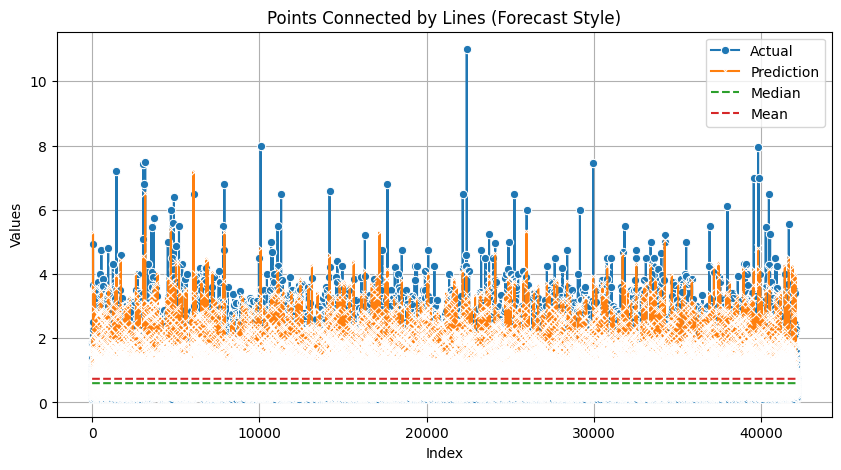

In [200]:
def make_forecast_plot(y, y_pred):
    idx = np.arange(len(y))  # X-axis indexes
    y_median = [np.median(y)] * len(y)
    y_mean = [np.mean(y)] * len(y)

    df = pd.DataFrame({
        "Index": idx,
        "y": y,
        "y_pred": y_pred,
        "y_median": y_median,
        "y_mean": y_mean
    })

    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df, x="Index", y="y", label="Actual", marker="o")
    sns.lineplot(data=df, x="Index", y="y_pred", label="Prediction", marker="x")
    sns.lineplot(data=df, x="Index", y="y_median", label="Median", linestyle="--")
    sns.lineplot(data=df, x="Index", y="y_mean", label="Mean", linestyle="--")

    plt.xlabel("Index")
    plt.ylabel("Values")
    plt.title("Points Connected by Lines (Forecast Style)")
    plt.grid(True)
    plt.show()

# Call with your arrays
make_forecast_plot(y_train, y_train_pred)

In [194]:
regressor = GradientBoostingRegressor(
    n_estimators = 235,
    min_samples_split = 7,
    max_depth = 6,
    max_features = 'sqrt',
    learning_rate = 0.03349386910874345,
    subsample =  0.5818341770483574,
)

transformer = FunctionTransformer(
                    func = lambda x:x,
                    inverse_func = lambda x:x
                )

model_pipeline = Pipeline(steps=[
                ("model", TransformedTargetRegressor(
                    regressor=regressor,
                    transformer=transformer
                ))
            ])

model_pipeline.fit(X_train_preprocessed,y_train)
y_train_pred = model_pipeline.predict(X_train_preprocessed)
y_val_pred = model_pipeline.predict(X_val_preprocessed)
y_test_pred = model_pipeline.predict(X_test_preprocessed)

train_mae = mean_absolute_error(y_train,y_train_pred)
val_mae = mean_absolute_error(y_val,y_val_pred)
test_mae = mean_absolute_error(y_test,y_test_pred)

train_r2 = r2_score(y_train,y_train_pred)
val_r2 = r2_score(y_val,y_val_pred)
test_r2 = r2_score(y_test,y_test_pred)

train_rmse = root_mean_squared_error(y_train,y_train_pred)
val_rmse = root_mean_squared_error(y_val,y_val_pred)
test_rmse = root_mean_squared_error(y_test,y_test_pred)

results_df = pd.DataFrame({
                            "data": ["train","val","test"],
                            "mae": [train_mae,val_mae,test_mae],
                            "r2_score": [train_r2,val_r2,test_r2],
                            "rmse": [train_rmse,val_rmse,test_rmse]
}).set_index("data")

results_df

,mae,r2_score,rmse
data,,,
train,0.165730,0.822960,0.235942
val,0.171879,0.799674,0.254880
test,0.175399,0.783987,0.259004


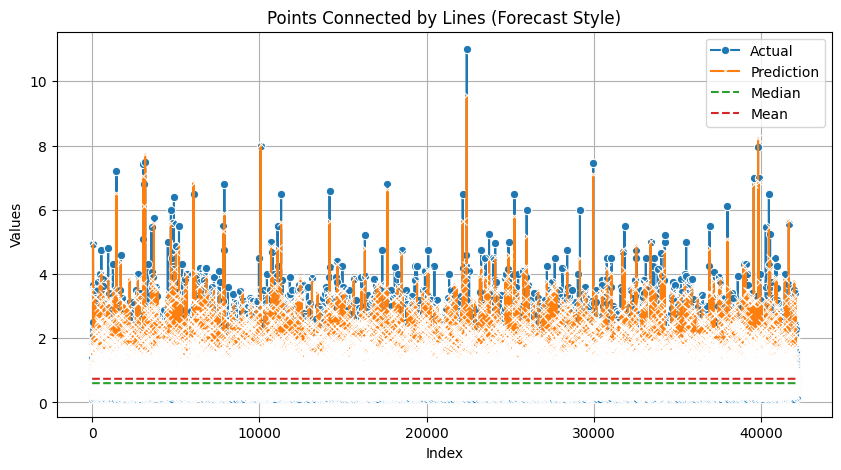

In [196]:
def make_forecast_plot(y, y_pred):
    idx = np.arange(len(y))  # X-axis indexes
    y_median = [np.median(y)] * len(y)
    y_mean = [np.mean(y)] * len(y)

    df = pd.DataFrame({
        "Index": idx,
        "y": y,
        "y_pred": y_pred,
        "y_median": y_median,
        "y_mean": y_mean
    })

    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df, x="Index", y="y", label="Actual", marker="o")
    sns.lineplot(data=df, x="Index", y="y_pred", label="Prediction", marker="x")
    sns.lineplot(data=df, x="Index", y="y_median", label="Median", linestyle="--")
    sns.lineplot(data=df, x="Index", y="y_mean", label="Mean", linestyle="--")

    plt.xlabel("Index")
    plt.ylabel("Values")
    plt.title("Points Connected by Lines (Forecast Style)")
    plt.grid(True)
    plt.show()

# Call with your arrays
make_forecast_plot(y_train, y_train_pred)

- The model optimized on `root_mean_sqaured_error` is capturing outliers better
- The final model chosen will have the following parameters

 | Hyperparameter      | Value                     |
|---------------------|---------------------------|
| learning_rate       | 0.03349386910874345       |
| max_depth           | 6                         |
| max_features        | sqrt                      |
| min_samples_split   | 7                         |
| n_estimators        | 235                       |
| regressor           | GradientBoostingRegressor |
| subsample           | 0.5818341770483574        |
| target_transformer  | same                      |


In [221]:
mean_predictor_rmse = root_mean_squared_error(y_test,np.array([np.mean(y_test)]*y_test.shape[0]))
predicted_rmse  = root_mean_squared_error(y_test,y_test_pred)
mean_predictor_mae = mean_absolute_error(y_test,np.array([np.mean(y_test)]*y_test.shape[0]))
predicted_mae  = mean_absolute_error(y_test,y_test_pred)

print(f'The decrease in rmse due to the model compared to simply predicting the mean is {abs(predicted_rmse - mean_predictor_rmse)*100/mean_predictor_rmse:.2f} % in the test dataset')
print(f'The decrease in rmse due to the model compared to simply predicting the mean is {abs(predicted_mae - mean_predictor_mae)*100/mean_predictor_mae:.2f} % in the test dataset')
print(f'The model explains {r2_score(y_test,y_test_pred)*100:.2f}% variance in the target variable in test dataset')

The decrease in rmse due to the model compared to simply predicting the mean is 51.20 % in the test dataset
The decrease in rmse due to the model compared to simply predicting the mean is 51.94 % in the test dataset
The model explains 76.18% variance in the target variable in test dataset
